# Domain Specific Code Generation using the FormLang DSL

## Abstract

AI and LLM systems are being trained to perform a variety of complex tasks requiring expertise in many software tools, languages and technology stacks. Some of the challenges in this process involve quality data acquisition in large amounts, handling the increase of model parameter count which leads to increasing compute demands and costs, as well as emerging Data Privacy and Intellctual Property concerns related with using 3rd party cloud services for model training.

In this work we attempt to harness and combine the benefits of Abstraction and Determinism provided by Formal Domain Specific Languages (DSLs) with the innate ability of LLMs to learn new languages and their semantics. We propose a novel generation task called "Domain Specific Code Generation" which involve mapping user requests written in natural language to DSL code.

By utilizing a specially crafted DSL called `FormLang` as a case study, we attempt to lay the groundwork for methods of automated DSL dataset generation, training techniques and performance evaluation, with the end goal of creating an AI system capable of generating Web forms according to a user request. If successful and viable, these methods can be applied to other problem domains in which real-world processes can be formally modelled using DSLs, opening the door to the training of AI agents that understand these DSLs and can be engineered to perform tasks autonomously.

Our `FormLang` DSL allows expressing the semantics of Web-forms using a simplified syntax that does not require much, if any, Web-programming knowledge and expertise.

Given a user prompt in English describing the desired form and its fields the LLM produces syntactically valid `FormLang` output which is run through the accompanying FormLang parser and a hand-crafted React JSX compiler to output a final implementation of the form in JavaScript and React.


## Referring to this work

If you use this work the following quote is preferred:

```bibtex
@misc{guyor2025dscodegenformlang,
      title={Domain Specific Code Generation using the FormLang DSL},
      author={Guy Or},
      year={2025}
}
```

The official repository of this work is hosted in GitHub at https://github.com/guyo13/Form-Lang.

## Project Goals

* Create an AI training pipeline for FormLang (implemented as a Juypter notebook) which includes:
    * Automatic FormLang Dataset generation using searching algorithms and heuristics.
    * Baseline model selection and loading from Hugging Face.
    * Dataset Preprocessing and loading.
    * Defining performance metrics for the model.
    * Model fine tuning using Transformers library
    * Model Adapter training using PEFT library.
    * Model upload to Hugging Face Hub and example usage from the Hub.
    *  **(TBD)** Export to ONNX using Optimum and run on-device using Transformers.js.
* Create the “FormLang” language:
    * Describe the problem domain.
    * Defining a viable minimal syntax and semantics which are research focused rather than completeness focused.
    *  **(TBD)** Implementing a “JavaScript React” compile target.
*  **(TBD)** Create a live demo website:
    * **(TBD)** Users input a prompt.
    * **(TBD)** A FormLang editor is populated with the AI’s code generation results.
    * **(TBD)** The form is rendered alongside the generated code.
*  Discuss the project results:
    * Perfornace and user acceptability.
    * **(TBD)** Viability of the implemented methods for the Domain Specific Code Generation task and generalization to other domains.  
    * **(TBD)** Potential enhancements to the system.
    * **(TBD)** Possible research directions on how to learn from user data.


**(TBD)** - Features marked as TBD are depending on the project's progress and timeline constraints as well as proving the viability of the methods and system.

# Dataset generation

## Generating the dataset

The `ProbabilisticSearchFormGenerator` is class implemeting a parameterized algorithm for randomly generating forms:

* Iterate Depth-First, start with an empty form definition.
* For each item off the frontier if the item is a Field, append it to its Parent Form.
* If the item is a Form, generate its children and add them onto the frontier. Generate children according to the following rules:
    * Assign to the child node $depth = parentDepth + 1$.
    * There is a probability of $\alpha^{d}$ of generating a random child Form where $0 \leq \alpha < 1$ and $d$ is the depth of the child.
    * There is an optional parameter $D$ for defining the maximum depth for nested forms, which sets to $0$ the probability to generate a nested Form if its depth will be $D$.
    * There is a probability of $1 - \alpha^{d}$ of generating a random child Field.
    * The number of generated children is a random number in the range of $[0, maxChildren]$.
    * There is a probability of $\beta$ that a generated Field will contain a `state`.
      * There is a probability of $\gamma$ that a state definition will be an `array`.
        * The number of array elements will be chosen at random from the integer interval $[0, amax]$.
      * There is an equal probability of the state `type` to be any of the supported built-in types.
      * There is a probability of $\delta$ that a state definition will contain a `default` value.
        * If the `type` is `string` there is an $\epsilon$ probability of the default value to be defined as `as expression`, otherwise the probability is $1$.
* For each item off the frontier chose a random component from a set of available components.
  * Choose at random the number of assigned component props from the range $[0, ComponentPropCount]$.
    * For each assigned prop generate a random value with $\epsilon$ probability of the value to be defined as `as expression`

The algorithm ranomly generates the tree structure of the form which is then serialized into `FormLang` source code.

Some of the main advatages of using probabilistic search is the simplicity of implementation as well as the ability to create datasets representing different distributions by adjusting the generation hyper parameters.

### TODO discuss disadvantages and how I try to solve them

In [38]:
import random
import pandas as pd

def generate_random_permutations(num_permutations=10, seed=None):
    """Generates random permutations of the probabilisticSearchParamsSchema without duplicates."""

    probability_values = [i / 10 for i in range(10)]
    integer_values = list(range(11))
    if seed is not None:
        random.seed(seed)

    permutations = set() # Use a set to store unique permutations
    while len(permutations) < num_permutations:
        permutation = {
            "alpha": random.choice(probability_values),
            "beta": random.choice(probability_values),
            "gamma": random.choice(probability_values),
            "delta": random.choice(probability_values),
            "epsilon": random.choice(probability_values),
            "zeta": random.choice(probability_values),
            "D": random.choice(integer_values[1:]), # make sure D is always positive
            "maxChildren": random.randint(1, 10),
            "amax": random.choice(integer_values),
        }

        # Convert the dictionary to a tuple of tuples for set hashing
        permutation_tuple = tuple(sorted(permutation.items()))
        permutations.add(permutation_tuple)

    # Convert the set of tuples back to a list of dictionaries
    permutation_list = [dict(item) for item in permutations]

    return pd.DataFrame(permutation_list)

# Generate and print the DataFrame
hyper_param_set = generate_random_permutations(1000, seed=42)
hyper_param_set

,D,alpha,amax,beta,delta,epsilon,gamma,maxChildren,zeta
0,4,0.0,0,0.2,0.9,0.1,0.4,1,0.6
1,1,0.4,9,0.8,0.0,0.2,0.9,4,0.5
2,1,0.8,8,0.9,0.2,0.6,0.2,2,0.8
3,8,0.7,2,0.8,0.3,0.7,0.1,5,0.6
4,1,0.7,4,0.9,0.8,0.7,0.0,7,0.4
...,...,...,...,...,...,...,...,...,...
995,3,0.8,1,0.1,0.2,0.3,0.2,4,0.6
996,4,0.3,0,0.8,0.8,0.2,0.7,2,0.9
997,2,0.6,1,0.7,0.8,0.8,0.8,1,0.6
998,6,0.2,4,0.5,0.4,0.1,0.2,7,0.0


from matplotlib import pyplot as plt
hyper_param_set['D'].plot(kind='hist', bins=20, title='D')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
hyper_param_set['alpha'].plot(kind='hist', bins=20, title='alpha')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
hyper_param_set['amax'].plot(kind='hist', bins=20, title='amax')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
hyper_param_set['beta'].plot(kind='hist', bins=20, title='beta')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
hyper_param_set.plot(kind='scatter', x='D', y='alpha', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
hyper_param_set.plot(kind='scatter', x='alpha', y='amax', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
hyper_param_set.plot(kind='scatter', x='amax', y='beta', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
hyper_param_set.plot(kind='scatter', x='beta', y='delta', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
hyper_param_set['D'].plot(kind='line', figsize=(8, 4), title='D')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
hyper_param_set['alpha'].plot(kind='line', figsize=(8, 4), title='alpha')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
hyper_param_set['amax'].plot(kind='line', figsize=(8, 4), title='amax')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
hyper_param_set['beta'].plot(kind='line', figsize=(8, 4), title='beta')
plt.gca().spines[['top', 'right']].set_visible(False)

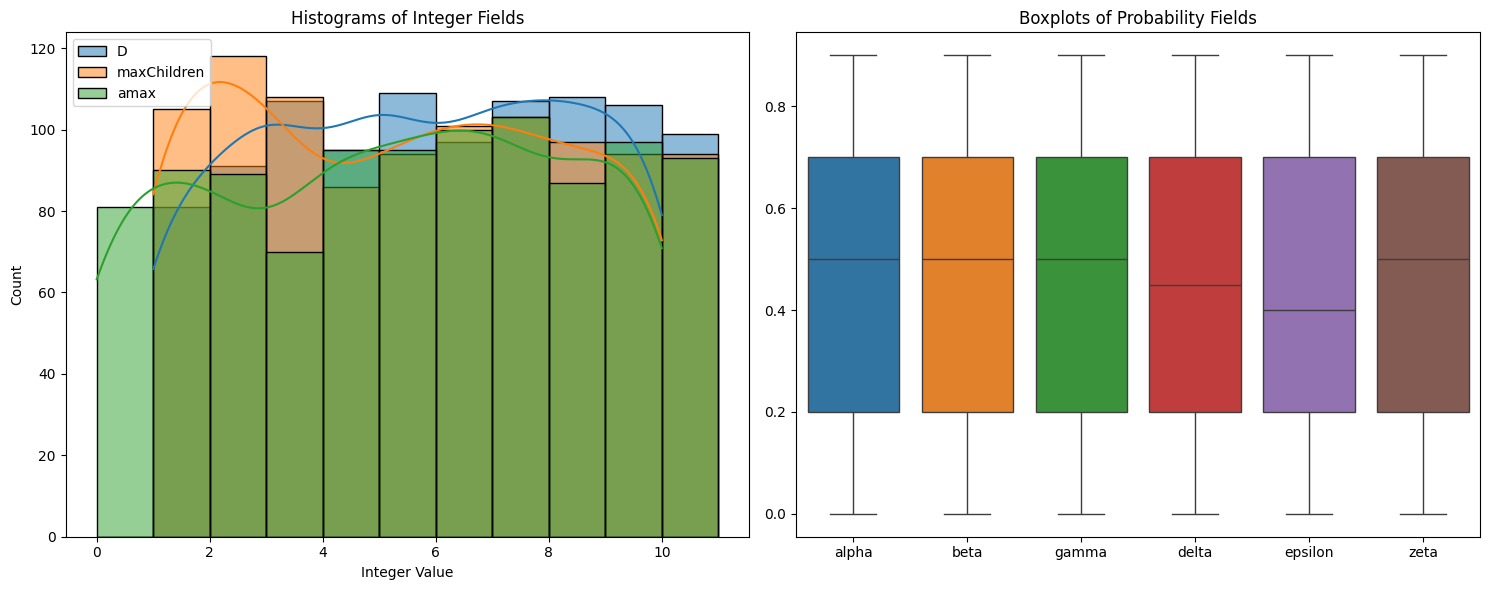

In [47]:
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def visualize_data(df):
    """Creates histograms and boxplots side by side with consistent bins and legend in top left."""

    probability_fields = ["alpha", "beta", "gamma", "delta", "epsilon", "zeta"]
    integer_fields = ["D", "maxChildren", "amax"]

    plt.figure(figsize=(15, 6))

    # Histograms for integer fields with consistent bins
    plt.subplot(1, 2, 1)
    all_integer_values = pd.concat([df[field].dropna() for field in integer_fields])
    bins = range(int(all_integer_values.min()), int(all_integer_values.max()) + 2)  # Consistent bins

    for field in integer_fields:
        sns.histplot(df[field].dropna(), bins=bins, kde=True, label=field)
    plt.title("Histograms of Integer Fields")
    plt.xlabel("Integer Value")
    plt.legend(loc='upper left') # Legend in top left

    # Boxplots for probability fields
    plt.subplot(1, 2, 2)
    sns.boxplot(data=df[probability_fields])
    plt.title("Boxplots of Probability Fields")

    plt.tight_layout()
    plt.show()


# Visualize the data
visualize_data(hyper_param_set)

We start by creating a [ProbabilisticSearchFormGenerator](https://github.com/guyo13/Form-Lang/blob/react_compiler/src/generation/formGen.ts#L102) object which is implemented in JavaScript, using the default search hyper parameters and some hard-coded Component definitions.

Later on we will implement a random generator for the component definitions as well.

In [ ]:
form_components = """
  component userDetailsContainer {}
  component formContainer {}
  component someOtherContainer {}
  component OtherContainer2 {}
  component Grid {}
  component Table {}
"""
field_components = """
  component myTextBox {
    props {
      textColor
      textSize
      textWeight
      borderColor
    }
  }
  component myCheckbox {
    props {
      size
    }
  }
  component otherTextBox {}
  component counter {
    props {
      style
    }
  }
  component mySelect {
    props {
      options
    }
  }
  component myRadio {
    props {
      options
    }
  }
  component myButton {
    props {
      text
    }
  }
  component myTextArea {
    props {
      rows
      cols
    }
  }
"""

form_gen = await formlang_lib.newFormGen(formlang_lib.DEFAULT_GENERATOR_HYPER_PARAMETERS, form_components, field_components)

### Create a data generation loop for the prompt data

#### Prompt-Data generation algorithm

Each training example consists of a randomly generated form, from-which we remove (or "mask") a random node, keep track of the removed node's parent and siblings.

The goal being to create a prompt that provides the masked form and describes in English the node that needs to be added along with its location in the form.

The algoithm is as follows:

* Generate a random Form - outputs $F$.
* Serialize the Form to FormLang code - outputs $s(F)$.
* Iterate Depth-First starting at the form's root.
  * For every node the probability of removing the node is $1 - \zeta^{depth(node)}, (0 < \zeta < 1)$ if no node was removed, else the probability is $ 0 $.
  * If a node is marked to be removed, recording its surrounding context and remove it from the tree. - $F \to (F', N, ctx(F, N))$.
* Serialize the modified Form to FormLang code - outputs $s(F')$.
* Generate Prompt instruction parts:
* Serialize the removed child node into plain English - outputs $eng(N)$.
* Serialize the Parent and Siblings nodes ids and node types (form/field) into plain English - outputs $eng(ctx(F, N))$.
* Output a dict consisting of $s(F), s(F'), eng(N), eng(ctx(F, N))$

The algorithm is implemented in TypeScript in the [generateRandomFormWithModification](https://github.com/guyo13/Form-Lang/blob/react_compiler/src/lib/generator.ts#L43) function.

We create a small dataset of 3000 random examples by using the JavaScript FormLang utilities library and the form generator object.

We copy from the form generator's output only the relevant fields which will make up the LLM prompt.

For each generated example we also compute the original form's AST and store it as part of the dataset.

In [ ]:
# TODO - Refactor data generator pipeline as a Python class with easy interfaces

def concat_components_code_with_form_code(form_code, form_components, field_components):
    """Concatenates the form code with the given components code that are referenced inside of it."""
    return f"{form_components}\n{field_components}\n{form_code}"

def create_prompt_data(generation_result, form_components, field_components):
    data = {
        "originalFormCode": concat_components_code_with_form_code(generation_result["serializedForm"], form_components, field_components),
        "modifiedFormCode": concat_components_code_with_form_code(generation_result["serializedModifiedForm"], form_components, field_components),
        "removedNodeEnglish": str(generation_result["removedNodeEnglish"]),
        "removedNodeContextEnglish": str(generation_result["removedNodeContextEnglish"]),
    }
    return data

def create_random_data(form_gen, form_components, field_components, num_examples=3000):
    start_time = time.time()
    DATA = []
    for i in range(num_examples):
        generation_result = formlang_lib.generateRandomFormWithModification(form_gen)
        prompt_data = create_prompt_data(generation_result, form_components, field_components)
        DATA.append(prompt_data)
    # Generate the ast of each example in one batch
    ast_time = time.time()
    for example in DATA:
        resp = get_ast(example["originalFormCode"], True)
        errors = resp.get('errors', [])
        if len(errors) > 0:
            print(f"Error parsing generated code", errors)
            raise RuntimeError("Error parsing generated code")
        example["originalFormAst"] = resp["ast"]
    end_time = time.time()
    print(f"Generation took {end_time - start_time} seconds. Total Ast generation time {end_time - ast_time} seconds")
    return pd.DataFrame(DATA)

In [ ]:
examples = create_random_data(form_gen, form_components, field_components, 3000)
examples.head()

Generation took 48.5854971408844 seconds. Total Ast generation time 47.7074978351593 seconds


,originalFormCode,modifiedFormCode,removedNodeEnglish,removedNodeContextEnglish,originalFormAst
0,\n component userDetailsContainer {}\n compo...,\n component userDetailsContainer {}\n compo...,\ta field whose id is 'Z_' with state of type:...,* is a child of the form whose id is 'Bw'.\n* ...,"{""$type"":""Form"",""name"":""Bw"",""component"":{""$typ..."
1,\n component userDetailsContainer {}\n compo...,\n component userDetailsContainer {}\n compo...,\ta field whose id is 'p_' with state of type:...,* is a child of the form whose id is 'Cw'.\n* ...,"{""$type"":""Form"",""name"":""Cw"",""component"":{""$typ..."
2,\n component userDetailsContainer {}\n compo...,\n component userDetailsContainer {}\n compo...,\ta field whose id is 'F' using the component ...,* is a child of the form whose id is 'Vw'.\n* ...,"{""$type"":""Form"",""name"":""Vw"",""component"":{""$typ..."
3,\n component userDetailsContainer {}\n compo...,\n component userDetailsContainer {}\n compo...,\t\ta field whose id is 'Pww_ww___w' using the...,* is a child of the form whose id is 'd'.\n* i...,"{""$type"":""Form"",""name"":""Lw"",""component"":{""$typ..."
4,\n component userDetailsContainer {}\n compo...,\n component userDetailsContainer {}\n compo...,\ta field whose id is 'nw' with state of type:...,* is a child of the form whose id is 'a_'.\n* ...,"{""$type"":""Form"",""name"":""a_"",""component"":{""$typ..."


#### Example generated FormLang code and its AST

In [ ]:
examples["originalFormCode"][1132]

'\n  component userDetailsContainer {}\n  component formContainer {}\n  component someOtherContainer {}\n  component OtherContainer2 {}\n\n\n  component myTextBox {\n    props {\n      textColor\n      textSize\n      textWeight\n      borderColor\n    }\n  }\n  component myCheckbox {\n    props {\n      size\n    }\n  }\n  component otherTextBox {}\n  component counter {\n    props {\n      style\n    }\n  }\n\nform T_ {\n\tcomp userDetailsContainer \n\t\n\tform H {\n\t\tcomp userDetailsContainer \n\t\t\n\t\tfield Ew {\n\t\t\tcomp otherTextBox \n\t\t\t\n\t\t}\n\t\tfield Rw_w {\n\t\t\tcomp otherTextBox \n\t\t\t\n\t\t}\n\t\tfield F_ {\n\t\t\tstate number\n\t\t\tcomp myTextBox borderColor="#301410" textSize="(() => 97.65823852274963)()" as expression\n\t\t\t\n\t\t}\n\t}\n\n\tfield p___ {\n\t\tcomp otherTextBox \n\t\t\n\t}\n\tfield vw {\n\t\tstate string default "Frankie Kessler"\n\t\tcomp counter style="#5b426f"\n\t\t\n\t}\n\tfield f {\n\t\tcomp counter \n\t\t\n\t}\n\tfield q {\n\t\tstat

In [ ]:
examples["originalFormAst"][1132]

'{"$type":"Form","name":"T_","component":{"$type":"FieldComponentDef","componentId":{"$ref":"#/components@0"},"componentPropsKeys":[],"componentPropsValues":[]},"children":[{"$type":"Form","name":"H","component":{"$type":"FieldComponentDef","componentId":{"$ref":"#/components@0"},"componentPropsKeys":[],"componentPropsValues":[]},"children":[{"$type":"Field","name":"Ew","component":{"$type":"FieldComponentDef","componentId":{"$ref":"#/components@6"},"componentPropsKeys":[],"componentPropsValues":[]}},{"$type":"Field","name":"Rw_w","component":{"$type":"FieldComponentDef","componentId":{"$ref":"#/components@6"},"componentPropsKeys":[],"componentPropsValues":[]}},{"$type":"Field","name":"F_","state":{"$type":"FieldStateDef","type":"number","isArray":false},"component":{"$type":"FieldComponentDef","componentId":{"$ref":"#/components@4"},"componentPropsKeys":[{"$type":"ComponentPropKey","key":"borderColor"},{"$type":"ComponentPropKey","key":"textSize"}],"componentPropsValues":[{"$type":"Va

### Creating the user prompts

For each example in our synthetic dataset, we create the user prompt which will be used to train and test the LLM.

The user prompt consists of the modified FormLang code taken from each of our dataset examples along with the english description of the form element to add and its location (context) in the form.

In [ ]:
def create_prompt(row):
    return (
            "```FormLang\n"
            f"{row['modifiedFormCode']}\n"
            "```\n"
            "The description of the form element you need to add:\n"
            f"{row['removedNodeEnglish']}\n"
            "The description of the context in the form where you should add the element:\n"
            f"The element to be added:\n{row['removedNodeContextEnglish']}\n"
           )

In [ ]:
examples["userPrompt"] = examples.apply(create_prompt, axis=1)
examples.head()

,originalFormCode,modifiedFormCode,removedNodeEnglish,removedNodeContextEnglish,originalFormAst,userPrompt
0,\n component userDetailsContainer {}\n compo...,\n component userDetailsContainer {}\n compo...,\ta field whose id is 'Z_' with state of type:...,* is a child of the form whose id is 'Bw'.\n* ...,"{""$type"":""Form"",""name"":""Bw"",""component"":{""$typ...",```FormLang\n\n component userDetailsContaine...
1,\n component userDetailsContainer {}\n compo...,\n component userDetailsContainer {}\n compo...,\ta field whose id is 'p_' with state of type:...,* is a child of the form whose id is 'Cw'.\n* ...,"{""$type"":""Form"",""name"":""Cw"",""component"":{""$typ...",```FormLang\n\n component userDetailsContaine...
2,\n component userDetailsContainer {}\n compo...,\n component userDetailsContainer {}\n compo...,\ta field whose id is 'F' using the component ...,* is a child of the form whose id is 'Vw'.\n* ...,"{""$type"":""Form"",""name"":""Vw"",""component"":{""$typ...",```FormLang\n\n component userDetailsContaine...
3,\n component userDetailsContainer {}\n compo...,\n component userDetailsContainer {}\n compo...,\t\ta field whose id is 'Pww_ww___w' using the...,* is a child of the form whose id is 'd'.\n* i...,"{""$type"":""Form"",""name"":""Lw"",""component"":{""$typ...",```FormLang\n\n component userDetailsContaine...
4,\n component userDetailsContainer {}\n compo...,\n component userDetailsContainer {}\n compo...,\ta field whose id is 'nw' with state of type:...,* is a child of the form whose id is 'a_'.\n* ...,"{""$type"":""Form"",""name"":""a_"",""component"":{""$typ...",```FormLang\n\n component userDetailsContaine...


##### Example User Prompt vs. original Code

In [ ]:
print(examples['userPrompt'][0])

```FormLang

  component userDetailsContainer {}
  component formContainer {}
  component someOtherContainer {}
  component OtherContainer2 {}


  component myTextBox {
    props {
      textColor
      textSize
      textWeight
      borderColor
    }
  }
  component myCheckbox {
    props {
      size
    }
  }
  component otherTextBox {}
  component counter {
    props {
      style
    }
  }

form Bw {
	comp OtherContainer2 
	
	field G {
		comp myCheckbox size="'Hello'.toLowerCase()" as expression
		
	}
	form a {
		comp formContainer 
		
		field qw {
			state boolean[]
			comp otherTextBox 
			
		}
		field F__ {
			comp myTextBox 
			
		}
		field Y__ {
			state string default "'John Streich'" as expression
			comp myTextBox 
			
		}
		field S_w {
			state string
			comp myCheckbox size="#121310"
			
		}
		field N_ {
			state number default "0.17049162264892637" as expression
			comp counter 
			
		}
	}

	field pw_wwww_w__ {
		state boolean
		comp counter 
		
	}
	field J {
		state s

In [ ]:
print(examples['originalFormCode'][0])


  component userDetailsContainer {}
  component formContainer {}
  component someOtherContainer {}
  component OtherContainer2 {}


  component myTextBox {
    props {
      textColor
      textSize
      textWeight
      borderColor
    }
  }
  component myCheckbox {
    props {
      size
    }
  }
  component otherTextBox {}
  component counter {
    props {
      style
    }
  }

form Bw {
	comp OtherContainer2 
	
	field G {
		comp myCheckbox size="'Hello'.toLowerCase()" as expression
		
	}
	form a {
		comp formContainer 
		
		field qw {
			state boolean[]
			comp otherTextBox 
			
		}
		field F__ {
			comp myTextBox 
			
		}
		field Y__ {
			state string default "'John Streich'" as expression
			comp myTextBox 
			
		}
		field S_w {
			state string
			comp myCheckbox size="#121310"
			
		}
		field N_ {
			state number default "0.17049162264892637" as expression
			comp counter 
			
		}
	}

	field pw_wwww_w__ {
		state boolean
		comp counter 
		
	}
	field Z_ {
		state string
		com

### Creating a Dataset on HuggingFace using `Datasets`

First we've manually created a Dataset repository on the hugging-face hub for our [form-lang-examples](https://huggingface.co/datasets/guy-or/form-lang-examples) .

We then convert our `examples` DataFrame into a Dataset object and upload it to the Hub.


In [ ]:
ds = Dataset.from_pandas(examples)
ds.push_to_hub("guy-or/form-lang-examples", "3k_single_omission")
ds

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/30.0 [00:00<?, ?B/s]

Dataset({
    features: ['originalFormCode', 'modifiedFormCode', 'removedNodeEnglish', 'removedNodeContextEnglish', 'originalFormAst', 'userPrompt'],
    num_rows: 3000
})

# Zero-shot evaluation and Training using Llama 3.2-1B as a foundation model

We've selected Llama 3.2 1B Instruct as a foundantion model of our experimentation.

This is choice is driven by the popularity of the model and the abundace of resources and examples available online. Specifically the 1B version was chosen because it can run on consumer hardware and can be trained on free cloud resources.

Another important factor in this choice is Llama's large context size of 128K tokens, this allows us to experiment with large prompts and opens the door for building complex AI agents that can be fed with `FormLang`'s compiler messages and user feedback and adjust their responses.

Successfully demonstrating performance improvement after training the 1B version will justify further time and cost investment required for training larger models.

## Dataset Loading and Pre-processing

### Loading the Dataset from HuggingFace using `Datasets`

We load the Dataset from the Hub using `load_dataset` function. The dataset contains the raw user prompt and expected outputs.

In the next steps we will use these fields to create a full prompt which includes our system prompt and finally tokenize the prompt in preparation for running the model.

In [ ]:
ds_3k_single_omission = load_dataset("guy-or/form-lang-examples", "3k_single_omission")
ds_3k_single_omission_all = ds_3k_single_omission['train']
ds_3k_single_omission_all

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Dataset({
    features: ['originalFormCode', 'modifiedFormCode', 'removedNodeEnglish', 'removedNodeContextEnglish', 'originalFormAst', 'userPrompt'],
    num_rows: 3000
})

### Pre-processing using the Chat Template

In order to create prompts that effectively describe the task to our Llama 3.2 model, we need to format our prompt in a way that the model was trained to respond to.

This is called a [Prompt Template](https://www.llama.com/docs/model-cards-and-prompt-formats/llama3_1/#prompt-template), which consists of a **System prompt** which provides the initial context and guidelines for the model, followed by a **User prompt** containing the request and relevant data.

#### Loading the Llama Tokenizer

We load Llama's tokenizer using Huggingface `AutoTokenizer` class and leverage its [Chat templates](https://huggingface.co/docs/transformers/v4.48.2/en/chat_templating#introduction) capabilities which exposes a simple API for formatting our prompts into Llama's required Prompt Template.

In [ ]:
# Setting the padding side to left for generation - later  on for training we will use right
llama3_tok_for_inference = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-1B-Instruct", padding_side="left")
llama3_tok_for_inference.pad_token = "<|finetune_right_pad_id|>"

#### System prompt

Our System prompt instructs the LLM to generate the original form (the `originalFormCode` column) given the data present in the user prompt which we already created in the Dataset generation part.

In [ ]:
def get_system_prompt():
    return (
        "You are a code generation AI assistant.\n"
        "Your job is to generate valid FormLang code according to the instructions given below:\n"
        "Inspect the following FormLang Form definition, the start of the code will be denoted with ```FormLang and its end with ``` .\n"
        "After inspection, complete the Form's code according to the given a description of a new form element and a description of its location in the form.\n"
        "You may assume that the new form element to be added is always either a 'form' or a 'field'.\n"
        "Your output must be valid and compiler-friendly FormLang code only.\n"
        "If you are unsure of the FormLang syntax, try to infer it from the form code which is given below as an input."
        "Your answer will be evaluated using an AST comparison of your code to the expected code.\n"
        "Assume that the input code is valid and requires no modification other than the NEW code you must generate.\n"
        "You must output plain FormLang code without any additional text or delimiters.\n"
        "You must not change any part of the original input code other than adding the required element.\n"
    )



#### Creating the full chat prompts

We create an `inferencePrompt` column to store the input prompt which contains the templated system and user prompts. **This column is used for inference only.**

Since our model's generated text gets appended (according to the prompt template format) to the input prompt, we also create a `chat` column containing the final expected model output. **This column will be used for training the model on a Causal Language Modelling task**. This task uses the model inputs (the `chat` column) shifted by one position to the right as labels.

In [ ]:
def get_system_and_user_messages(userPrompt):
    return [
        {"role": "system", "content": get_system_prompt()},
        {"role": "user", "content": userPrompt}]

def get_full_conversation_messages(userPrompt, expectedOutput):
    messages = get_system_and_user_messages(userPrompt)
    messages.append({"role": "assistant", "content": expectedOutput})
    return messages

def preprocess_func(example, tokenizer):
    inference_prompt = tokenizer.apply_chat_template(get_system_and_user_messages(example["userPrompt"]), tokenize=False, add_generation_prompt=True)
    chat = tokenizer.apply_chat_template(get_full_conversation_messages(example["userPrompt"], example['originalFormCode']), tokenize=False, add_generation_prompt=False)
    return {"inferencePrompt": inference_prompt, "chat": chat}

In [ ]:
# Our preprocess_func doesn't support batch operations, we pass in our Llama tokenizer as an argument
ds_3k_with_prompts = ds_3k_single_omission_all.map(preprocess_func, batched=False, fn_kwargs={"tokenizer": llama3_tok_for_inference})
ds_3k_with_prompts

Dataset({
    features: ['originalFormCode', 'modifiedFormCode', 'removedNodeEnglish', 'removedNodeContextEnglish', 'originalFormAst', 'userPrompt', 'inferencePrompt', 'chat'],
    num_rows: 3000
})

In [ ]:
print(ds_3k_with_prompts[0]['inferencePrompt'])
print("#" * 50)
print(ds_3k_with_prompts[0]['chat'])

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 21 Feb 2025

You are a code generation AI assistant.
Your job is to generate valid FormLang code according to the instructions given below:
Inspect the following FormLang Form definition, the start of the code will be denoted with ```FormLang and its end with ``` .
After inspection, complete the Form's code according to the given a description of a new form element and a description of its location in the form.
You may assume that the new form element to be added is always either a 'form' or a 'field'.
Your output must be valid and compiler-friendly FormLang code only.
If you are unsure of the FormLang syntax, try to infer it from the form code which is given below as an input.Your answer will be evaluated using an AST comparison of your code to the expected code.
Assume that the input code is valid and requires no modification other than the NEW code you must generate.
You mu

#### Creating the Train-Validation-Test split

We allocate 80% for training and 10% for test and validation each.

Since we are able to generate arbitrarily large amounts of data with different distributions, these percentages does not matter too much.

In [ ]:
def create_train_validation_test_split(dataset, test_size):
    splits = dataset.train_test_split(test_size=test_size)
    test_splits = splits["test"].train_test_split(test_size=0.5) # Split so that test and validation sizes are equal
    return {"train": splits["train"], "test": test_splits["train"], "validation": test_splits["test"]}

ds_3k_splits = create_train_validation_test_split(ds_3k_with_prompts, 0.2)
ds_3k_train, ds_3k_test, ds_3k_val = ds_3k_splits["train"], ds_3k_splits["test"], ds_3k_splits["validation"]
ds_3k_train, ds_3k_test, ds_3k_val

(Dataset({
     features: ['originalFormCode', 'modifiedFormCode', 'removedNodeEnglish', 'removedNodeContextEnglish', 'originalFormAst', 'userPrompt', 'inferencePrompt', 'chat'],
     num_rows: 2400
 }),
 Dataset({
     features: ['originalFormCode', 'modifiedFormCode', 'removedNodeEnglish', 'removedNodeContextEnglish', 'originalFormAst', 'userPrompt', 'inferencePrompt', 'chat'],
     num_rows: 300
 }),
 Dataset({
     features: ['originalFormCode', 'modifiedFormCode', 'removedNodeEnglish', 'removedNodeContextEnglish', 'originalFormAst', 'userPrompt', 'inferencePrompt', 'chat'],
     num_rows: 300
 }))

## Post-Processing Utils

We create several utility functions for post processing the prompt data

### Extracting the model's response from the output text

Our model's raw output is a concatenation of the input and the generated text following Llama's Prompt Template semantics.

In order to extract the generated code we first need to identify the model's latest response by extracting all the text between the special `<|start_header_id|>assistant<|end_header_id|>` and `<|eot_id|>` tokens.

In [ ]:
# prompt: Create a function that accepts the output text and extracts all the text starting at the LATEST OCCURRENCE of "<|start_header_id|>assistant<|end_header_id|>" and ends with "<|eot_id|>"

def extract_latest_assistant_response(text):
    """
    Extracts the model's response from the output text.

    Args:
        text: The output text from the model.

    Returns:
        The extracted model response, or None if no response is found.
    """
    match = re.findall(r"<\|start_header_id\|>assistant<\|end_header_id\|>(.*?)<\|eot_id\|>", text, re.DOTALL)
    if match:
        return match[-1].strip()  # Return the latest occurrence
    else:
        return ""


### Extracting FormLang code from LLM output

The LLM might ignore the instruction to output plain code without the "```FormLang" delimiter, in that case we should try to extract the contents.

In [ ]:
def extract_code_block(text, lang):
  """
  Extracts a code block from a string.

  Args:
    text: The string containing the code block.
    lang: The name of the language the code block is written in.

  Returns:
    The code block, or None if no code block is found.
  """
  if text is None:
    return ""
  pattern = f"```{lang}\n(.*?)```"
  match = re.search(pattern, text, re.DOTALL)
  if match:
    return match.group(1).strip()
  return ""

def extract_llm_formlang_output(text):
    # Strip leading and trailing whitespace and check for delimiters
    text = text.strip()
    assistant_response = extract_latest_assistant_response(text)
    return extract_code_block(assistant_response, "FormLang") or assistant_response

### Running inference on a single example

In [ ]:
def clear_mem():
    """Clear unused GPU memory used by the python process"""
    import gc
    gc.collect()
    torch.cuda.empty_cache()

In [ ]:
def run_inference(model, tok, example, cuda=True):
    """Runs pre-processing, inference and post-processing on a single example."""
    example_inputs = tok(example, return_tensors="pt")
    if cuda:
        example_inputs = example_inputs.to("cuda")
    with torch.no_grad():
      example_outputs = model.generate(**example_inputs, max_new_tokens=10000)
    generated_text = tok.decode(example_outputs[0], skip_special_tokens=False)
    del example_inputs
    del example_outputs
    generated_code = extract_llm_formlang_output(generated_text)
    ast = get_ast(generated_code)
    return {"generated_code": generated_code, "generated_text": generated_text, "ast": ast}

## Zero-shot evaluation of Llama 3.2 1B using Transformers and Evaluate

### Defining the Performance metrics

Before attempting to train the model, we want to define perfomance metrics for the code generation task and evaluate the base model performance on some of our data in order to establish a baseline for performance.

We will measure several metrics:

* Exact Match
* BLEU (Geometric mean over n-gram BLEU with $n \in \{1,2,3,4\}$ and Berevity Penalty applied to the mean).
* ROUGE
* METEOR
* ChrF (Suggested as the best metric according to Mikhail Evtikhiev, Egor Bogomolov, Yaroslav Sokolov, Timofey Bryksin,
[Out of the BLEU paper](https://www.sciencedirect.com/science/article/abs/pii/S016412122300136X))

BLUE and ROUGE are standard metrics for measuring text generation performance when we want to compare the model's output to a desired output.

In the case of code generation, these metrics may not accurately reflect the quality of the model's output when applied to the source code and therefore we will try to apply them both on the serialized AST (in JSON format) of the generated code as well as the code itself and the raw output of the model vs the expected one.

**(TBD)** Try CodeBLEU and `apted` for tree edit distance algorithms that might better reflect the model's performance.

### Loading the metrics and creating evaluators

We load the evaluators for BLEU, ROUGE and Accuracy (using the "exact match" metric since our data is text).

In [ ]:
def get_bleu_meteor_chrf(keep_in_memory=True):
    bleu_metric = evaluate.load("bleu", module_type="metric", keep_in_memory=keep_in_memory)
    exact_match_metric = evaluate.load("exact_match", module_type="metric", keep_in_memory=keep_in_memory)
    meteor_metric = evaluate.load("meteor", module_type="metric", keep_in_memory=keep_in_memory)
    chrf_metric = evaluate.load("chrf", module_type="metric", keep_in_memory=keep_in_memory) # Output format {'score': 78.04486337325869, 'char_order': 6, 'word_order': 0, 'beta': 2}
    all_metrics = evaluate.combine([bleu_metric, exact_match_metric, meteor_metric, chrf_metric])
    return all_metrics

def get_all_metrics(keep_in_memory=True):
    bleu_metric = evaluate.load("bleu", module_type="metric", keep_in_memory=keep_in_memory)
    rouge_metric = evaluate.load("rouge", module_type="metric", keep_in_memory=keep_in_memory)
    exact_match_metric = evaluate.load("exact_match", module_type="metric", keep_in_memory=keep_in_memory)
    meteor_metric = evaluate.load("meteor", module_type="metric", keep_in_memory=keep_in_memory)
    chrf_metric = evaluate.load("chrf", module_type="metric", keep_in_memory=keep_in_memory) # Output format {'score': 78.04486337325869, 'char_order': 6, 'word_order': 0, 'beta': 2}
    all_metrics = evaluate.combine([bleu_metric, rouge_metric, exact_match_metric, meteor_metric, chrf_metric])
    return all_metrics

In [ ]:
all_metrics = get_all_metrics()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


#### Computing the metrics over our dataset columns

As an example to test the reliability of our metrics (specifically the BLEU and ROUGE scores), we check their average values on the examples from our train dataset.

We compare the similarity of the following pairs of data:

1) The expected raw output of the model (`chat`) compared to our `inferencePrompt`.

2) The original form source code (`originalFormCode`) and the modified form code (`modifiedFormCode`).

3) The AST of the original form source code and the AST of the modified form code.

In [ ]:
def extract_metric_relevant_columns(metrics_output):
  # {'bleu': 0.8429359658014339,
  # 'precisions': [0.9991243684963839,
  # 0.9964290396238203,
  # 0.9945622915127816,
  # 0.9943585183190857],
  # 'brevity_penalty': 0.8462220852319774,
  # 'length_ratio': 0.8569175306304484,
  # 'translation_length': 2740879,
  # 'reference_length': 3198533,
  # 'rouge1': 0.8370146985702014,
  # 'rouge2': 0.8334233528574165,
  # 'rougeL': 0.8369070588232945,
  # 'rougeLsum': 0.8370885974782589,
  # 'exact_match': 0.0,
  # 'meteor': 0.6904226543462031,
  # 'score': 87.7747112051328,
  # 'char_order': 6,
  # 'word_order': 0,
  # 'beta': 2}
  metrics = {}
  if 'bleu' in metrics_output:
    metrics['bleu'] = metrics_output['bleu']
    for i in range(len(metrics_output['precisions'])):
      metrics[f'bleu_{i+1}_gram'] = metrics_output['precisions'][i]
    metrics['bleu_brevity_penalty'] = metrics_output['brevity_penalty']
    metrics['bleu_length_ratio'] = metrics_output['length_ratio']
  if 'rouge1' in metrics_output:
    metrics['rouge1'] = metrics_output['rouge1']
  if 'rouge2' in metrics_output:
    metrics['rouge2'] = metrics_output['rouge2']
  if 'rougeL' in metrics_output:
    metrics['rougeL'] = metrics_output['rougeL']
  if 'rougeLsum' in metrics_output:
    metrics['rougeLsum'] = metrics_output['rougeLsum']
  if 'exact_match' in metrics_output:
    metrics['exact_match'] = metrics_output['exact_match']
  if 'meteor' in metrics_output:
    metrics['meteor'] = metrics_output['meteor']
  if 'score' in metrics_output:
    metrics['chrf'] = metrics_output['score']
  return metrics

In [ ]:
def compute_metric_and_return_dataframe(dataset, metric_fn, get_predictions, get_references):
  column_names = list(dataset.features)
  results = dataset.map(
      lambda example: extract_metric_relevant_columns(metric_fn.compute(predictions=get_predictions(example), references=get_references(example))),
      batched=False,
      num_proc=multiprocessing.cpu_count(),
      remove_columns=column_names
      )
  return results.to_pandas()

def compute_raw_output_metrics(dataset, metric_fn):
  get_predictions = lambda example: [example["inferencePrompt"]]
  get_references = lambda example: [example["chat"]]

  return compute_metric_and_return_dataframe(dataset, metric_fn, get_predictions, get_references)

def compute_source_code_metrics(dataset, metric_fn):
  get_predictions = lambda example: [example["modifiedFormCode"]]
  get_references = lambda example: [example["originalFormCode"]]

  return compute_metric_and_return_dataframe(dataset, metric_fn, get_predictions, get_references)

def compute_json_ast_metrics(dataset, metric_fn):
  get_predictions = lambda example: [get_ast(example["modifiedFormCode"])["ast"]]
  get_references = lambda example: [example["originalFormAst"]]

  return compute_metric_and_return_dataframe(dataset, metric_fn, get_predictions, get_references)

In [ ]:
# prompt: Create a function that takes in the dataframe of the scores, and for each score column in [bleu, rouge1, rouge2, rougeL, rougeLsum, meteor, chrf]  it plots a histogram of the score along with a KDE and the mean, median and standard deviation of the score, make sure the plots are organized in a grid of 3 columns

def plot_score_distributions(df):
    """
    Plots histograms and KDEs of scores, along with mean, median, and std.

    Args:
        df: Pandas DataFrame containing score columns.
    """

    score_columns = ['bleu', 'rouge1', 'rouge2', 'rougeL', 'rougeLsum', 'meteor', 'chrf']
    num_plots = len(score_columns)
    cols = 3
    rows = (num_plots + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    axes = axes.flatten()

    for i, col in enumerate(score_columns):
        if col in df.columns:  # Check if the column exists
            sns.histplot(df[col], kde=True, ax=axes[i], bins=20)
            mean = df[col].mean()
            median = df[col].median()
            std = df[col].std()
            axes[i].axvline(mean, color='r', linestyle='dashed', linewidth=1, label=f'Mean: {mean:.2f}')
            axes[i].axvline(median, color='g', linestyle='dashed', linewidth=1, label=f'Median: {median:.2f}')
            axes[i].set_title(f'Distribution of {col}')
            axes[i].legend()
        else:
            axes[i].set_title(f"Column '{col}' not found in dataframe")

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()


##### Metric results comparing Raw expected LLM output to input

In [ ]:
%%time
raw_llm_outputs_results = compute_raw_output_metrics(ds_3k_with_prompts, all_metrics)
raw_llm_outputs_results

Map (num_proc=12):   0%|          | 0/3000 [00:00<?, ? examples/s]

CPU times: user 2.8 s, sys: 876 ms, total: 3.68 s
Wall time: 2min 30s


,bleu,bleu_1_gram,bleu_2_gram,bleu_3_gram,bleu_4_gram,bleu_brevity_penalty,bleu_length_ratio,rouge1,rouge2,rougeL,rougeLsum,exact_match,meteor,chrf
0,0.723438,1.0,1.0,1.0,1.0,0.723438,0.755435,0.882682,0.882419,0.882682,0.882682,0.0,0.739376,77.864430
1,0.666144,1.0,1.0,1.0,1.0,0.666144,0.711111,0.865191,0.864919,0.865191,0.865191,0.0,0.709676,74.892285
2,0.738405,1.0,1.0,1.0,1.0,0.738405,0.767305,0.901619,0.901373,0.901619,0.901619,0.0,0.786414,80.251050
3,0.714351,1.0,1.0,1.0,1.0,0.714351,0.748290,0.887850,0.887588,0.887850,0.887850,0.0,0.754564,78.182639
4,0.749223,1.0,1.0,1.0,1.0,0.749223,0.775964,0.897129,0.896882,0.897129,0.897129,0.0,0.768023,79.779329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0.794313,1.0,1.0,1.0,1.0,0.794313,0.812825,0.917553,0.917333,0.917553,0.917553,0.0,0.803363,82.654319
2996,0.790830,1.0,1.0,1.0,1.0,0.790830,0.809932,0.921196,0.920981,0.921196,0.921196,0.0,0.808701,82.472086
2997,0.765560,1.0,1.0,1.0,1.0,0.765560,0.789174,0.911695,0.911483,0.911695,0.911695,0.0,0.806727,81.588925
2998,0.773212,1.0,1.0,1.0,1.0,0.773212,0.795417,0.903797,0.903553,0.903797,0.903797,0.0,0.781919,80.184497


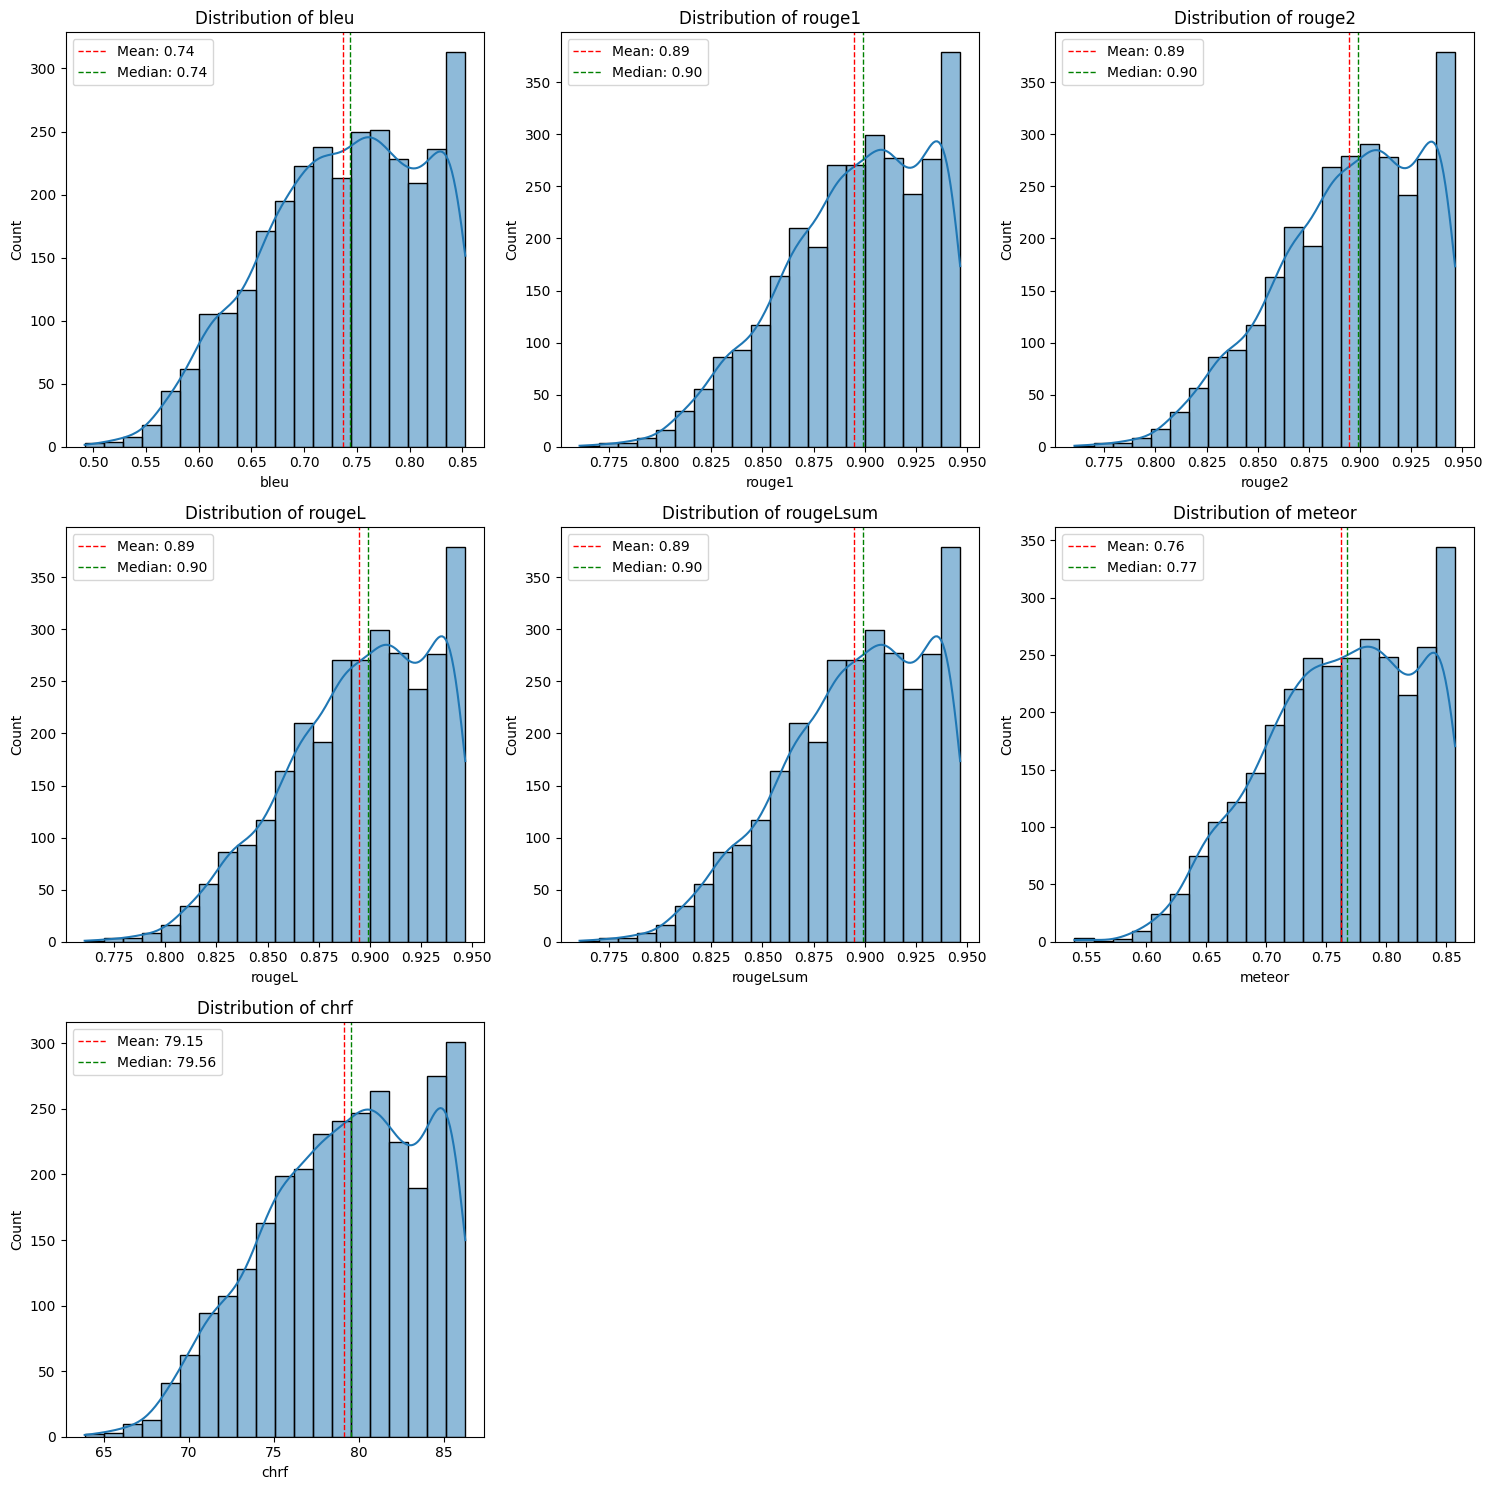

In [ ]:
plot_score_distributions(raw_llm_outputs_results)

##### Metric results comparing Expected Source-code output to the modified Source-code input

In [ ]:
%%time
source_code_results = compute_source_code_metrics(ds_3k_with_prompts, all_metrics)
source_code_results

Map (num_proc=2):   0%|          | 0/3000 [00:00<?, ? examples/s]

CPU times: user 9.86 s, sys: 1.41 s, total: 11.3 s
Wall time: 11min 12s


,bleu,bleu_1_gram,bleu_2_gram,bleu_3_gram,bleu_4_gram,bleu_brevity_penalty,bleu_length_ratio,rouge1,rouge2,rougeL,rougeLsum,exact_match,meteor,chrf
0,0.945127,1.0,1.0,1.000000,0.993789,0.946601,0.947977,0.970000,0.969697,0.970000,0.970000,0.0,0.863282,96.029207
1,0.780705,1.0,1.0,1.000000,0.995000,0.781683,0.802372,0.904564,0.903766,0.904564,0.904564,0.0,0.717356,89.075334
2,0.957771,1.0,1.0,1.000000,0.992958,0.959465,0.960265,0.973333,0.972973,0.973333,0.973333,0.0,0.906814,97.059312
3,0.888669,1.0,1.0,0.993631,0.987179,0.892965,0.898305,0.955556,0.955056,0.955556,0.955556,0.0,0.877245,94.116812
4,0.878974,1.0,1.0,0.992063,0.992000,0.882497,0.888889,0.936709,0.935897,0.936709,0.936709,0.0,0.751000,92.635101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0.936234,1.0,1.0,1.000000,0.989130,0.938795,0.940594,0.965517,0.964912,0.965517,0.965517,0.0,0.903497,96.479599
2996,0.902186,1.0,1.0,0.989247,0.978261,0.909612,0.913462,0.943396,0.942308,0.943396,0.943396,0.0,0.890207,94.234470
2997,0.874439,1.0,1.0,0.991870,0.983607,0.879853,0.886525,0.917293,0.900763,0.917293,0.917293,0.0,0.807162,90.004842
2998,0.925519,1.0,1.0,0.990741,0.990654,0.929854,0.932203,0.957746,0.957143,0.957746,0.957746,0.0,0.828438,95.526425


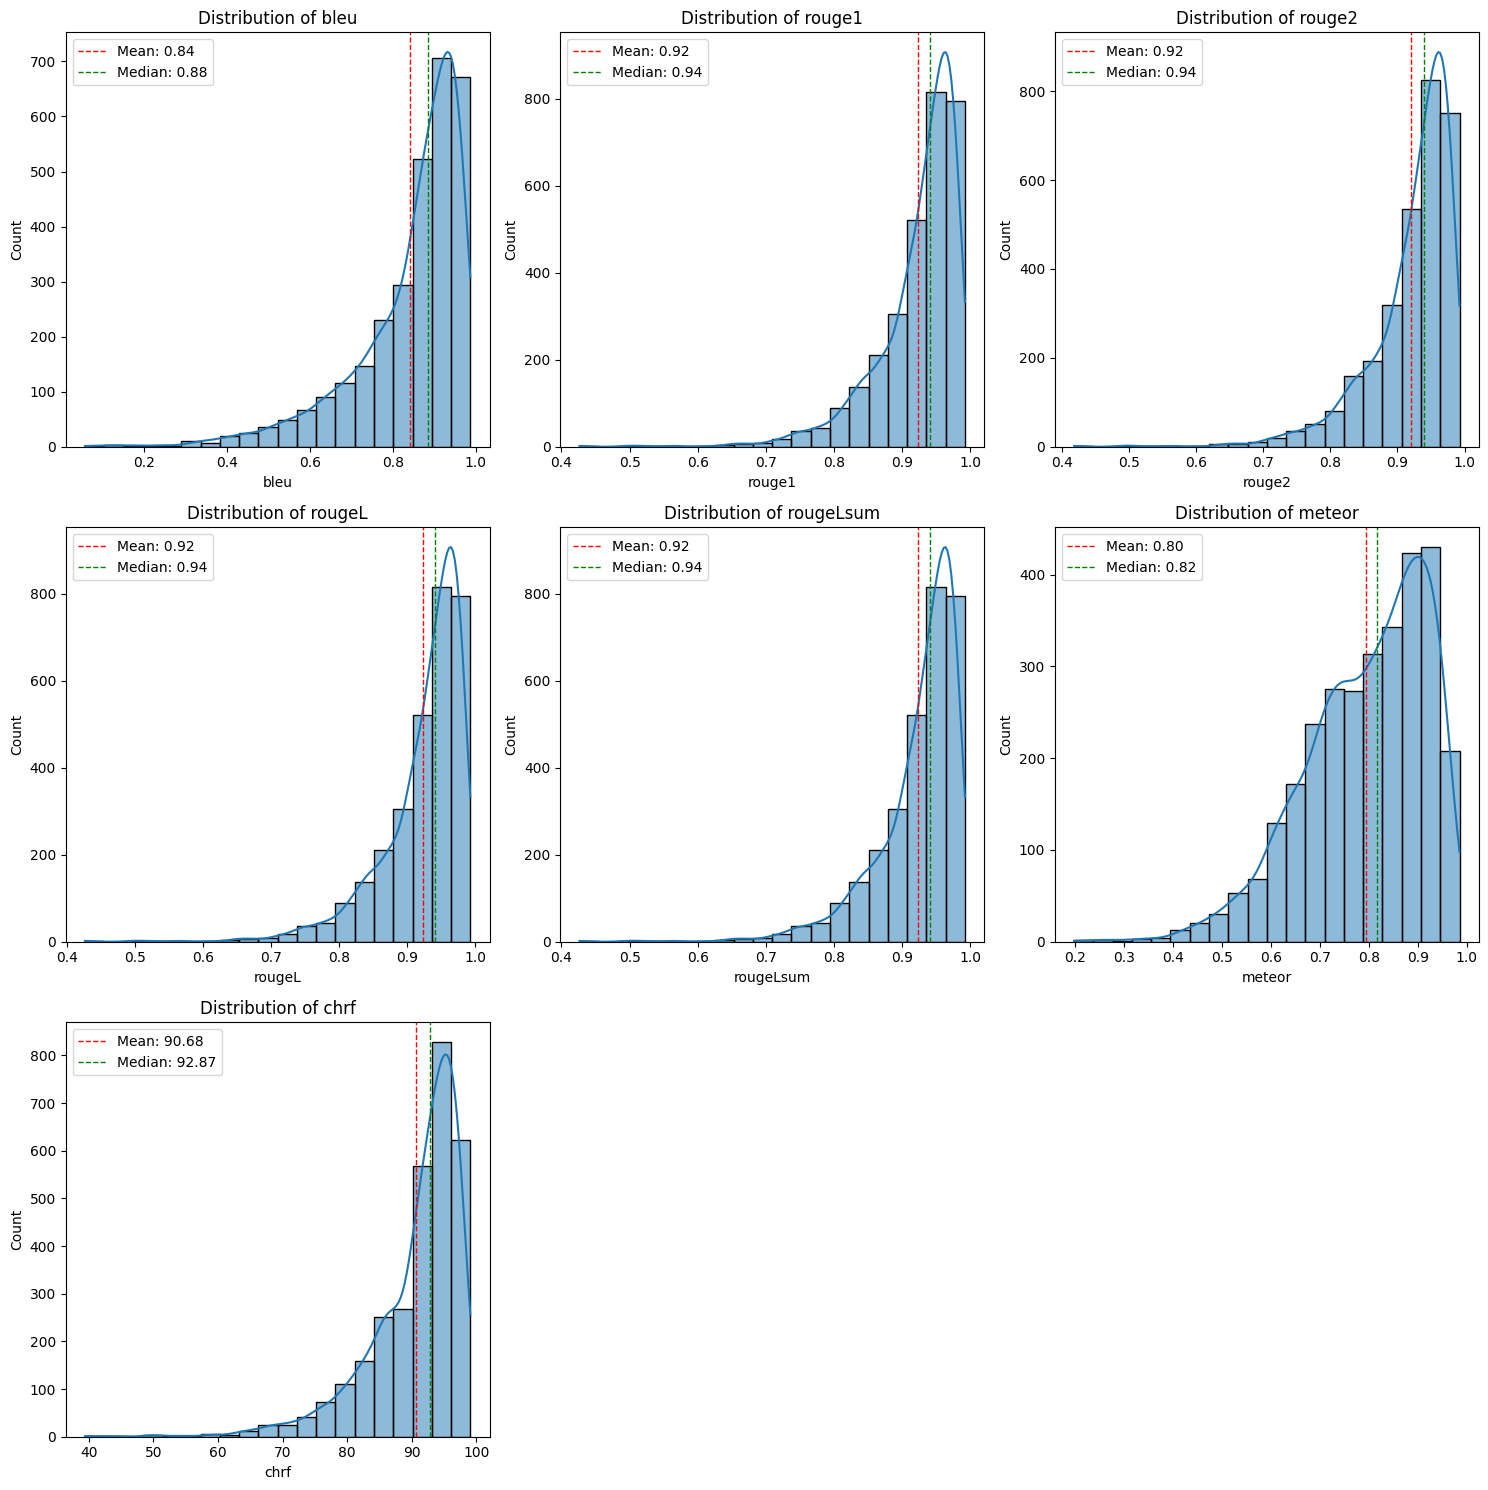

In [ ]:
plot_score_distributions(source_code_results)

##### Metric results comparing the AST of the expected output source code to the AST of the input source code

In [ ]:
%%time
json_ast_results = compute_json_ast_metrics(ds_3k_with_prompts, all_metrics)
json_ast_results

Map (num_proc=2):   0%|          | 0/3000 [00:00<?, ? examples/s]

CPU times: user 11.3 s, sys: 1.65 s, total: 12.9 s
Wall time: 13min 50s


,bleu,bleu_1_gram,bleu_2_gram,bleu_3_gram,bleu_4_gram,bleu_brevity_penalty,bleu_length_ratio,rouge1,rouge2,rougeL,rougeLsum,exact_match,meteor,chrf
0,0.908943,1.0,1.0,1.0,1.0,0.908943,0.912848,0.955357,0.955157,0.955357,0.955357,0.0,0.833322,93.080160
1,0.806820,1.0,1.0,1.0,1.0,0.806820,0.823279,0.894640,0.894249,0.894640,0.894640,0.0,0.697123,85.883346
2,0.888549,1.0,1.0,1.0,1.0,0.888549,0.894322,0.950192,0.949807,0.950192,0.950192,0.0,0.872115,91.409313
3,0.882497,1.0,1.0,1.0,1.0,0.882497,0.888889,0.939467,0.939173,0.939467,0.939467,0.0,0.858307,90.835372
4,0.842312,1.0,1.0,1.0,1.0,0.842312,0.853530,0.918478,0.918033,0.918478,0.918478,0.0,0.739054,87.960648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0.867665,1.0,1.0,1.0,1.0,0.867665,0.875696,0.937799,0.937198,0.937799,0.937799,0.0,0.873323,89.836074
2996,0.773141,1.0,1.0,1.0,1.0,0.773141,0.795359,0.891304,0.890110,0.891304,0.891304,0.0,0.813367,83.610350
2997,0.672501,1.0,1.0,1.0,1.0,0.672501,0.715947,0.841629,0.840183,0.841629,0.841629,0.0,0.651168,75.811567
2998,0.853271,1.0,1.0,1.0,1.0,0.853271,0.863053,0.927536,0.927007,0.927536,0.927536,0.0,0.743343,89.064081


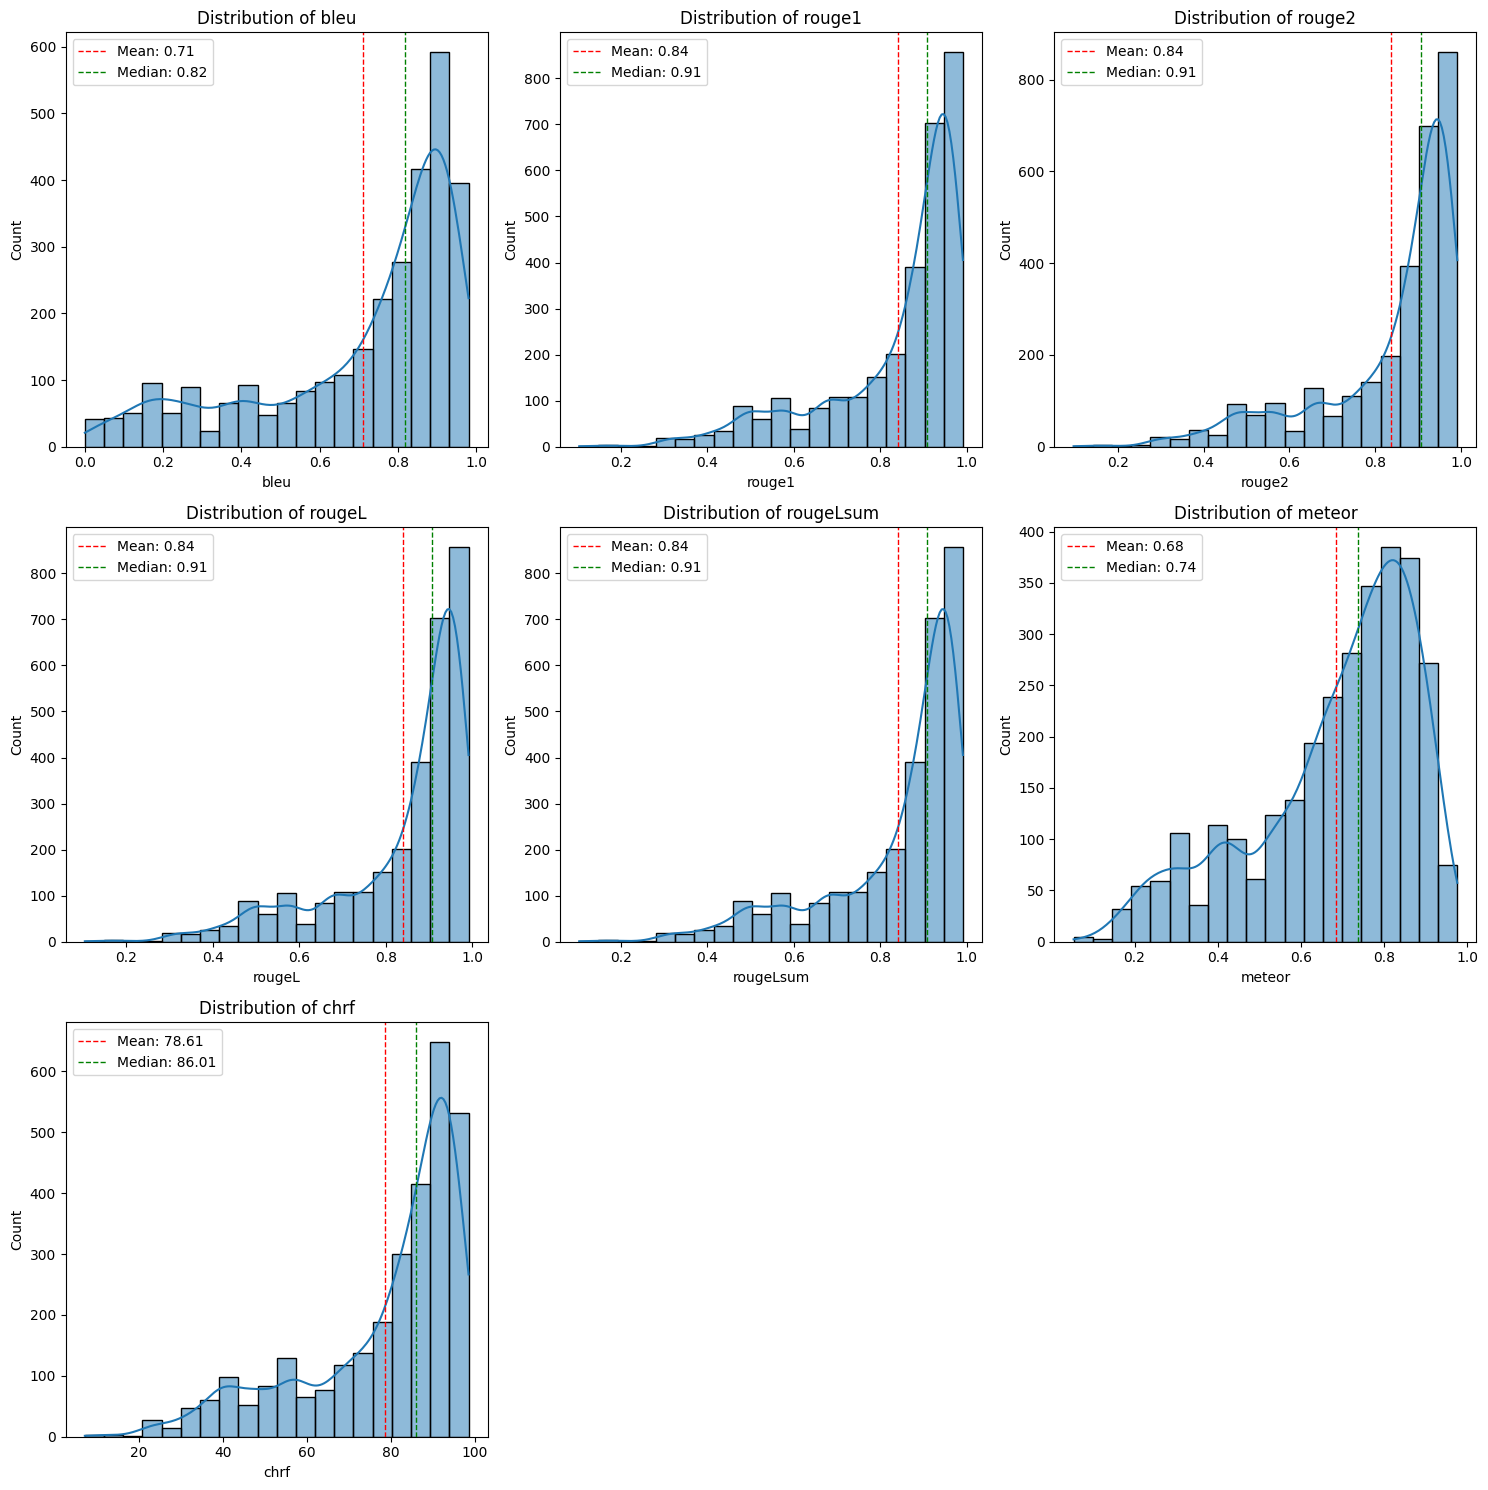

In [ ]:
plot_score_distributions(json_ast_results)

As we can see, except for the `exact_match` score, our input is very similar to our expected output according to the measured metrics across all data-pair comparisons.

This could mean on one hand that our trained model would have to exhibit scores that are very close to 100% in order to demonstrate a significant improvement,

And on the other hand scores that are far below the above scores are probably bad even if they are above 80%.

We might also need to adjust our data generation algorithm to remove more nodes from the form (instead of a single omission algorithm for our example dataset).

For model evaluation we will use the `BLEU`, `METEOR` and `ChRF` metrics as they exhibit similar distribution to all the `ROUGE` variants which take a relatively long time to compute.

In [ ]:
def evaluate_model(model, tokenizer, raw_text_evaluations, source_code_evaluations, ast_evaluations, dataset, batch_size=16):
  model.eval()
  all_predictions = []

  def evaluate_batch(batch):
    inputs = None
    outputs = None
    input_ids = None
    attention_mask = None
    try:
      inputs = tokenizer(batch["inferencePrompt"], return_tensors="pt", padding=True, truncation=False).to("cuda") # TODO pad_to_multiple_of=1024
      input_ids = inputs["input_ids"]
      attention_mask = inputs["attention_mask"]
      with torch.no_grad():
          t0 = time.time()
          print("generating")
          outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask)
          print(f"batch generated. took {time.time() - t0} seconds")

      # Evaluate output raw text vs. expected raw text
      raw_text_predictions = tokenizer.batch_decode(outputs, skip_special_tokens=True) # For the raw text evaluation we do skip special tokens because we want to be agnostic of any padding
      raw_text_references = tokenizer.batch_decode(tokenizer(batch["chat"], return_tensors="pt", padding=True, truncation=False).input_ids, skip_special_tokens=True) # Create full expected text references by removing special tokens
      raw_text_evaluations.add_batch(predictions=raw_text_predictions, references=raw_text_references)

      # Evaluate the source code output
      raw_llm_predictions = tokenizer.batch_decode(outputs, skip_special_tokens=False) # We dont skip special tokens because we need them to know how to extract the LLMs latest response
      source_code_predictions = [extract_llm_formlang_output(output) or "" for output in raw_llm_predictions]
      source_code_references = [original_code for original_code in batch["originalFormCode"]]
      source_code_evaluations.add_batch(predictions=source_code_predictions, references=source_code_references)

      # Evaluate the AST output - TODO Deal with errors
      #ast_predictions = [json.dumps(get_ast(code)) for code in form_lang_predictions]
      #ast_references = [ast for ast in batch["originalFormAst"]]
      #ast_evaluations.add_batch(predictions=ast_predictions, references=ast_references)

      # Add the llm outputs to the list and return it from the function
      all_predictions.extend(raw_llm_predictions)
      print("added to eval")
    except:
      print("got exception")
      import traceback
      traceback.print_exc()
    finally:
      # Free GPU memory
      del inputs
      del outputs
      del input_ids
      del attention_mask

  for batch in tqdm(dataset.iter(batch_size)):
    evaluate_batch(batch)

  return raw_text_evaluations, source_code_evaluations, ast_evaluations, all_predictions


### Zero-shot evaluation with the original Meta version

We the original Llama 3.2 1B model available from Meta and run an evaluation over our validation dataset

##### Initialize the model

In [ ]:
llama3_model = AutoModelForCausalLM.from_pretrained(
    "meta-llama/Llama-3.2-1B-Instruct",
    torch_dtype=torch.bfloat16,
    device_map="cuda",
    attn_implementation="flash_attention_2"
)

config.json:   0%|          | 0.00/877 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

##### Override default generation config

In [ ]:
llama3_model.generation_config.pad_token_id = llama3_tok_for_inference.pad_token_id
llama3_model.generation_config.temperature = 0.9
llama3_model.generation_config.max_new_tokens = 1024
print(llama3_model.generation_config)

GenerationConfig {
  "bos_token_id": 128000,
  "do_sample": true,
  "eos_token_id": [
    128001,
    128008,
    128009
  ],
  "max_new_tokens": 1024,
  "pad_token_id": 128004,
  "temperature": 0.9,
  "top_p": 0.9
}



##### [EXPERIMENT] Trying with static cache and torch compile

Only supported when `attn_implementation="sdpa"` - **slower than FA2**

In [ ]:
#llama3_model.generation_config.cache_implementation = "static"

#llama3_model.forward = torch.compile(llama3_model.forward, mode="reduce-overhead", fullgraph=True)

##### [EXPERIMENT] Trying with Quantized Cache

**Increases latency relative to the default DynamicCache**

In [ ]:
# Configure Quantized Cache
quantized_cache_config = QuantizedCacheConfig(
    nbits=4,  # Use 4-bit quantization
    q_group_size=64,  # Adjust if necessary
    residual_length=128,  # Adjust if necessary
)

#llama3_model.generation_config.cache_implementation = "quantized"
#llama3_model.generation_config.quantized_cache_config = quantized_cache_config

##### Trying to evaluate the first 50 examples in our validation dataset

In [ ]:
first_examples = ds_3k_val.train_test_split(test_size=(50/300))["test"]

In [ ]:
raw_text_evaluations, source_code_evaluations, ast_evaluations, all_predictions = evaluate_model(llama3_model, llama3_tok_for_inference, get_bleu_meteor_chrf(), get_bleu_meteor_chrf(), get_bleu_meteor_chrf(), first_examples, batch_size=50)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_

0it [00:00, ?it/s]

generating
batch generated. took 67.42545938491821 seconds
added to eval


In [ ]:
llama3_tok_for_inference(all_predictions, return_tensors="pt", padding=True, truncation=False).input_ids.shape

torch.Size([50, 1753])

In [ ]:
print(all_predictions[42])

<|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|>

In [ ]:
print(extract_llm_formlang_output(all_predictions[42]))

component userDetailsContainer {}
  component formContainer {}
  component someOtherContainer {}
  component OtherContainer2 {}

  component myTextBox {
    props {
      textColor
      textSize
      textWeight
      borderColor
    }
  }
  component myCheckbox {
    props {
      size
    }
  }
  component otherTextBox {}
  component counter {
    props {
      style
    }
  }

  component gw {
    comp OtherContainer2 
    field id="qw" type="number"
    props textColor="#2f5276"
    textSize="#523067"
    textWeight="#383061"
    borderColor="#2f5660"
  }


In [ ]:
print(extract_llm_formlang_output(first_examples[42]["chat"]))

component userDetailsContainer {}
  component formContainer {}
  component someOtherContainer {}
  component OtherContainer2 {}


  component myTextBox {
    props {
      textColor
      textSize
      textWeight
      borderColor
    }
  }
  component myCheckbox {
    props {
      size
    }
  }
  component otherTextBox {}
  component counter {
    props {
      style
    }
  }

form gw {
	comp OtherContainer2 
	
	field qw {
		state number
		comp myTextBox textColor="#2f5276" textSize="#523067" textWeight="#383061" borderColor="#2f5660"
		
	}
}


In [ ]:
raw_text_evaluations.compute()

{'bleu': 0.9003100125972453,
 'precisions': [0.919347984458475,
  0.9050586733142822,
  0.8935269760077944,
  0.8836982374824663],
 'brevity_penalty': 1.0,
 'length_ratio': 1.0514154405897935,
 'translation_length': 32944,
 'reference_length': 31333,
 'rouge1': 0.9482152254161769,
 'rouge2': 0.9333667894401422,
 'rougeL': 0.93519168962034,
 'rougeLsum': 0.9484624191071347,
 'exact_match': 0.0}

In [ ]:
source_code_evaluations.compute()

{'bleu': 0.7925345856532497,
 'precisions': [0.9052563270603504,
  0.8615284128020901,
  0.8197238658777121,
  0.7843812045003309],
 'brevity_penalty': 0.9418012026122038,
 'length_ratio': 0.9434308803722297,
 'translation_length': 7705,
 'reference_length': 8167,
 'rouge1': 0.8594792255623867,
 'rouge2': 0.8006840527857084,
 'rougeL': 0.7981545069180424,
 'rougeLsum': 0.8586316529420399,
 'exact_match': 0.0}

In [ ]:
# TODO
#ast_evaluations.compute()

In [ ]:
del llama3_model
clear_mem()

## Fine-Tuning LoRA adapter for LLama 3.2 1B

In [ ]:
def get_lora_trainer(model_id, model_kwargs, output_dir, train_dataset, eval_dataset, dataset_text_field, tokenizer, compute_metrics, max_seq_length, packing=False, push_to_hub=False, num_train_epochs=1):
  training_args = SFTConfig(
      model_init_kwargs=model_kwargs,
      bf16=True, # specify bf16=True instead when training on GPUs that support bf16
      do_eval=True,
      eval_strategy="epoch",
      gradient_checkpointing=True,
      gradient_checkpointing_kwargs={"use_reentrant": False},
      learning_rate=2.0e-05,
      log_level="info",
      logging_steps=5,
      logging_strategy="steps",
      lr_scheduler_type="cosine",
      max_steps=-1,
      num_train_epochs=num_train_epochs,
      output_dir=output_dir,
      overwrite_output_dir=True,
      gradient_accumulation_steps=20,
      per_device_eval_batch_size=2, # originally set to 8
      per_device_train_batch_size=2, # originally set to 8
      eval_accumulation_steps=10, # Insanely important otherwise all the evaluations are going to OOM the GPU!!!
      push_to_hub=push_to_hub,
      hub_strategy="all_checkpoints",
      report_to="tensorboard",
      save_strategy="epoch",
      save_total_limit=None,
      seed=42,
      max_seq_length=max_seq_length,#tokenizer.model_max_length,
      dataset_text_field=dataset_text_field,
      packing=packing
  )

  # Check that the max_seq_length is not shorter than our longest prompt
  all_prompts_tokenized = tokenizer(eval_dataset[dataset_text_field])["input_ids"]
  longest_prompt_index = np.argmax(np.array(list(map(lambda x:len(x), all_prompts_tokenized))))
  longest_prompt = all_prompts_tokenized[longest_prompt_index]
  longest_prompt_length = len(longest_prompt)
  if longest_prompt_length > max_seq_length:
    raise ValueError(f"max_seq_length  of {max_seq_length} is shorter than the longest prompt of length {longest_prompt_length}")

  # based on config
  peft_config = LoraConfig(
          r=64,
          lora_alpha=16,
          lora_dropout=0.1,
          bias="none",
          task_type="CAUSAL_LM",
          target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
  )

  from functools import partial
  compute_metrics = partial(compute_metrics, packed=True) if packing else compute_metrics

  trainer = SFTTrainer(
          model=model_id,
          args=training_args,
          train_dataset=train_dataset,
          eval_dataset=eval_dataset,
          tokenizer=tokenizer,
          peft_config=peft_config,
          compute_metrics=compute_metrics,
          preprocess_logits_for_metrics=lambda logits, labels: torch.argmax(logits, dim=-1), # This allows us to reduce the size of the logits stored on the GPU and use a larger eval_accumulation_steps value
      )
  return trainer, training_args

def train_with_lora(trainer, training_args, train_dataset, resume_from_checkpoint=False):
  train_result = trainer.train(resume_from_checkpoint=resume_from_checkpoint)
  try:
    log_trainer_metrics(trainer, train_result, train_dataset)
  except:
    print("got exception")
    import traceback
    traceback.print_exc()
  finally:
    clear_mem()
    return train_result


def log_trainer_metrics(trainer, train_result, train_dataset):
  metrics = train_result.metrics
  metrics["train_samples"] = len(train_dataset)
  trainer.log_metrics("train", metrics)
  trainer.save_metrics("train", metrics)
  trainer.save_state()

In [ ]:
llama3_tok_for_train = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-1B-Instruct", padding_side="right")
llama3_tok_for_train.pad_token = "<|finetune_right_pad_id|>"

In [ ]:
training_metrics = get_bleu_meteor_chrf()

def prefix_dict_keys(d, prefix):
  return {f"{prefix}_{k}": v for k, v in d.items()}

def iter_ast(source_codes):
  asts = []
  for i in tqdm(range(len(source_codes))):
    code = source_codes[i]
    asts.append(get_ast(code)['ast'])
  return asts

def compute_metrics(eval_pred, packed=False):
    logits, labels = eval_pred  # eval_pred contains logits and labels
    if len(logits) == 3:
      print("Taking argmax over logits")
      # The predicted token ID is the one with the maximum logit
      predictions = np.argmax(logits, axis=-1)
    else:
      predictions = logits


    print("Logits shape:", logits.shape)       # (batch_size, seq_len, vocab_size)
    print("Labels shape:", labels.shape)       # (batch_size, seq_len)
    print("Predictions shape:", predictions.shape) # (batch_size, seq_len)

    predictions = np.where(predictions == -100 , llama3_tok_for_train.pad_token_id, predictions)
    labels = np.where(labels == -100, llama3_tok_for_train.pad_token_id, labels)

    raw_text_predictions = llama3_tok_for_train.batch_decode(predictions, skip_special_tokens=False)
    raw_text_labels = llama3_tok_for_train.batch_decode(labels, skip_special_tokens=False)

    # Metrics over the raw generated text
    raw_text_eval = Dataset.from_dict({"raw_text_predictions": raw_text_predictions, "raw_text_labels": raw_text_labels})
    raw_text_avg_metrics = compute_metric_and_return_dataframe(raw_text_eval, training_metrics, lambda example: [example["raw_text_predictions"]], lambda example: [example["raw_text_labels"]]).mean().to_dict()

    source_code_predictions = [extract_llm_formlang_output(output) for output in raw_text_predictions]
    source_code_references = []
    for label in raw_text_labels:
      ref = extract_llm_formlang_output(label)
      if ref == "" or ref is None:
        raise ValueError(f"ERROR, reference source code is empty! '{ref}'\nlabel:\n{label}")
      source_code_references.append(ref)
    source_code_eval = Dataset.from_dict({"source_code_predictions": source_code_predictions, "source_code_references": source_code_references})
    source_code_avg_metrics = compute_metric_and_return_dataframe(source_code_eval, training_metrics, lambda example: [example["source_code_predictions"]], lambda example: [example["source_code_references"]]).mean().to_dict()

    # Evaluate the AST output
    ast_predictions = iter_ast(source_code_predictions)
    ast_references = iter_ast(source_code_references)
    ast_eval = Dataset.from_dict({"ast_predictions": ast_predictions, "ast_references": ast_references})
    ast_avg_metrics = compute_metric_and_return_dataframe(source_code_eval, training_metrics, lambda example: [example["source_code_predictions"]], lambda example: [example["source_code_references"]]).mean().to_dict()

    # Calculate accuracy - TODO something is broken here
    # correct = np.sum(predictions == labels)
    # total = len(labels)
    # accuracy = correct / total if total > 0 else 0.0

    all_metrics = {} # {"accuracy": accuracy}
    all_metrics.update(prefix_dict_keys(raw_text_avg_metrics, "raw_text"))
    all_metrics.update(prefix_dict_keys(source_code_avg_metrics, "source_code"))
    all_metrics.update(prefix_dict_keys(ast_avg_metrics, "ast"))

    return all_metrics


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
output_dir = "./formlang-lora-experiment-Llama-3.2-1B-Instruct"
trainer, training_args = get_lora_trainer("meta-llama/Llama-3.2-1B-Instruct",
    {"torch_dtype": torch.bfloat16,
    "device_map": "cuda",
    "attn_implementation":"flash_attention_2",
     "use_cache": False},
      output_dir,
      ds_3k_train,
      ds_3k_val,
      "chat",
      llama3_tok_for_train,
      compute_metrics,
      4096,
      push_to_hub=True, num_train_epochs=10
)


<ipython-input-35-085f00244ba4>:54: FutureWarning: `tokenizer` is deprecated and removed starting from version 0.16.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  trainer = SFTTrainer(


Converting train dataset to ChatML:   0%|          | 0/2400 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/2400 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/2400 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/2400 [00:00<?, ? examples/s]

Converting eval dataset to ChatML:   0%|          | 0/300 [00:00<?, ? examples/s]

Applying chat template to eval dataset:   0%|          | 0/300 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/300 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/300 [00:00<?, ? examples/s]

You have loaded a model on multiple GPUs. `is_model_parallel` attribute will be force-set to `True` to avoid any unexpected behavior such as device placement mismatching.
Using auto half precision backend


##### Run an evaluation loop before training

In [ ]:
pre_train_results = trainer.evaluate(trainer.eval_dataset)
pd.DataFrame([pre_train_results])

The following columns in the evaluation set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: inferencePrompt, removedNodeEnglish, removedNodeContextEnglish, userPrompt, chat, originalFormCode, originalFormAst, modifiedFormCode. If inferencePrompt, removedNodeEnglish, removedNodeContextEnglish, userPrompt, chat, originalFormCode, originalFormAst, modifiedFormCode are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 300
  Batch size = 1


Logits shape: (300, 2669)
Labels shape: (300, 2669)
Predictions shape: (300, 2669)


Map (num_proc=12):   0%|          | 0/300 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/300 [00:00<?, ? examples/s]

,eval_loss,eval_model_preparation_time,eval_accuracy,eval_raw_text_bleu,eval_raw_text_bleu_1_gram,eval_raw_text_bleu_2_gram,eval_raw_text_bleu_3_gram,eval_raw_text_bleu_4_gram,eval_raw_text_bleu_brevity_penalty,eval_raw_text_bleu_length_ratio,...,eval_source_code_bleu_3_gram,eval_source_code_bleu_4_gram,eval_source_code_bleu_brevity_penalty,eval_source_code_bleu_length_ratio,eval_source_code_exact_match,eval_source_code_meteor,eval_source_code_chrf,eval_runtime,eval_samples_per_second,eval_steps_per_second
0,2.316252,0.0084,1800.513333,0.977493,0.990368,0.980418,0.975767,0.973364,0.997473,0.99748,...,0.900537,0.880056,0.996553,1.004311,0.0,0.93461,94.175767,57.271,5.238,5.238


##### TRAINING

In [ ]:
train_with_lora(trainer, training_args, ds_3k_train)

The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: removedNodeContextEnglish, inferencePrompt, userPrompt, originalFormCode, removedNodeEnglish, originalFormAst, chat, modifiedFormCode. If removedNodeContextEnglish, inferencePrompt, userPrompt, originalFormCode, removedNodeEnglish, originalFormAst, chat, modifiedFormCode are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 2,400
  Num Epochs = 1
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 40
  Gradient Accumulation steps = 20
  Total optimization steps = 60
  Number of trainable parameters = 13,631,488


Epoch,Training Loss,Validation Loss,Accuracy,Raw Text Bleu,Raw Text Bleu 1 Gram,Raw Text Bleu 2 Gram,Raw Text Bleu 3 Gram,Raw Text Bleu 4 Gram,Raw Text Bleu Brevity Penalty,Raw Text Bleu Length Ratio,Raw Text Exact Match,Raw Text Meteor,Raw Text Chrf,Source Code Bleu,Source Code Bleu 1 Gram,Source Code Bleu 2 Gram,Source Code Bleu 3 Gram,Source Code Bleu 4 Gram,Source Code Bleu Brevity Penalty,Source Code Bleu Length Ratio,Source Code Exact Match,Source Code Meteor,Source Code Chrf,Ast Bleu,Ast Bleu 1 Gram,Ast Bleu 2 Gram,Ast Bleu 3 Gram,Ast Bleu 4 Gram,Ast Bleu Brevity Penalty,Ast Bleu Length Ratio,Ast Exact Match,Ast Meteor,Ast Chrf
1,2.018000,2.028525,1600.633333,0.875576,0.975980,0.964625,0.959233,0.956427,0.902249,0.914492,0.000000,0.887148,90.098909,0.917477,0.951608,0.928469,0.906560,0.888173,0.999165,1.011103,0.000000,0.945294,94.836944,0.917477,0.951608,0.928469,0.906560,0.888173,0.999165,1.011103,0.000000,0.945294,94.836944


Saving model checkpoint to ./formlang-lora-experiment-Llama-3.2-1B-Instruct/checkpoint-60
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--meta-llama--Llama-3.2-1B-Instruct/snapshots/9213176726f574b556790deb65791e0c5aa438b6/config.json
Model config LlamaConfig {
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": [
    128001,
    128008,
    128009
  ],
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "factor": 32.0,
    "high_freq_factor": 4.0,
    "low_freq_factor": 1.0,
    "original_max_position_embeddings": 8192,
    "rope_type": "llama3"

Logits shape: (300, 2669)
Labels shape: (300, 2669)
Predictions shape: (300, 2669)


Map (num_proc=12):   0%|          | 0/300 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/300 [00:00<?, ? examples/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

Map (num_proc=12):   0%|          | 0/300 [00:00<?, ? examples/s]

Saving model checkpoint to ./formlang-lora-experiment-Llama-3.2-1B-Instruct/checkpoint-60
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--meta-llama--Llama-3.2-1B-Instruct/snapshots/9213176726f574b556790deb65791e0c5aa438b6/config.json
Model config LlamaConfig {
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": [
    128001,
    128008,
    128009
  ],
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "factor": 32.0,
    "high_freq_factor": 4.0,
    "low_freq_factor": 1.0,
    "original_max_position_embeddings": 8192,
    "rope_type": "llama3"

got exception


In [ ]:
train_result = train_with_lora(trainer, training_args, ds_3k_train, resume_from_checkpoint=True)

Loading model from ./formlang-lora-experiment-Llama-3.2-1B-Instruct/checkpoint-60.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: chat, originalFormCode, inferencePrompt, originalFormAst, removedNodeEnglish, removedNodeContextEnglish, modifiedFormCode, userPrompt. If chat, originalFormCode, inferencePrompt, originalFormAst, removedNodeEnglish, removedNodeContextEnglish, modifiedFormCode, userPrompt are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 2,400
  Num Epochs = 10
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 40
  Gradient Accumulation steps = 20
  Total optimization steps = 600
  Number of trainable parameters = 13,631,488
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 1
  Continuing train

Epoch,Training Loss,Validation Loss,Accuracy,Raw Text Bleu,Raw Text Bleu 1 Gram,Raw Text Bleu 2 Gram,Raw Text Bleu 3 Gram,Raw Text Bleu 4 Gram,Raw Text Bleu Brevity Penalty,Raw Text Bleu Length Ratio,Raw Text Exact Match,Raw Text Meteor,Raw Text Chrf,Source Code Bleu,Source Code Bleu 1 Gram,Source Code Bleu 2 Gram,Source Code Bleu 3 Gram,Source Code Bleu 4 Gram,Source Code Bleu Brevity Penalty,Source Code Bleu Length Ratio,Source Code Exact Match,Source Code Meteor,Source Code Chrf,Ast Bleu,Ast Bleu 1 Gram,Ast Bleu 2 Gram,Ast Bleu 3 Gram,Ast Bleu 4 Gram,Ast Bleu Brevity Penalty,Ast Bleu Length Ratio,Ast Exact Match,Ast Meteor,Ast Chrf
2,1.457900,1.436895,1051.803333,0.836833,0.964711,0.948496,0.939117,0.933402,0.871930,0.891133,0.000000,0.862247,87.313204,0.948317,0.981711,0.962128,0.942658,0.926653,0.995049,0.997489,0.010000,0.960472,97.495259,0.948317,0.981711,0.962128,0.942658,0.926653,0.995049,0.997489,0.010000,0.960472,97.495259
3,0.686700,0.655963,1051.043333,0.849283,0.971015,0.963773,0.958646,0.954783,0.871417,0.890631,0.000000,0.877012,88.691492,0.960713,0.986926,0.971842,0.956729,0.943236,0.996085,0.997989,0.030000,0.974800,98.243500,0.960713,0.986926,0.971842,0.956729,0.943236,0.996085,0.997989,0.030000,0.974800,98.243500
4,0.452100,0.445951,1050.346667,0.853039,0.972524,0.967278,0.963609,0.961086,0.871823,0.891000,0.000000,0.881553,89.015440,0.972050,0.990314,0.979675,0.968729,0.958679,0.997741,0.999095,0.050000,0.984288,98.788216,0.972050,0.990314,0.979675,0.968729,0.958679,0.997741,0.999095,0.050000,0.984288,98.788216
5,0.389700,0.397530,1050.096667,0.853728,0.972605,0.967767,0.964299,0.961825,0.872093,0.891263,0.000000,0.882645,89.061250,0.977414,0.992324,0.983801,0.974659,0.966316,0.998165,0.999495,0.100000,0.989043,99.060367,0.977414,0.992324,0.983801,0.974659,0.966316,0.998165,0.999495,0.100000,0.989043,99.060367
6,0.388300,0.376960,1049.713333,0.853939,0.972616,0.967950,0.964534,0.962087,0.872141,0.891317,0.000000,0.882833,89.074881,0.980617,0.993157,0.985969,0.977950,0.970795,0.998675,0.999991,0.150000,0.990834,99.212783,0.980617,0.993157,0.985969,0.977950,0.970795,0.998675,0.999991,0.150000,0.990834,99.212783
7,0.384600,0.366555,1049.613333,0.854072,0.972652,0.968074,0.964676,0.962241,0.872174,0.891333,0.000000,0.882989,89.077970,0.981890,0.993604,0.986915,0.979366,0.972682,0.998771,0.999910,0.180000,0.991415,99.266969,0.981890,0.993604,0.986915,0.979366,0.972682,0.998771,0.999910,0.180000,0.991415,99.266969
8,0.371700,0.361717,1049.636667,0.854134,0.972663,0.968111,0.964756,0.962322,0.872187,0.891348,0.000000,0.883067,89.081087,0.983277,0.993789,0.987725,0.980854,0.974682,0.999040,1.000259,0.220000,0.991930,99.342704,0.983277,0.993789,0.987725,0.980854,0.974682,0.999040,1.000259,0.220000,0.991930,99.342704
9,0.388900,0.360012,1049.580000,0.854171,0.972673,0.968150,0.964793,0.962362,0.872204,0.891354,0.000000,0.883106,89.082139,0.983297,0.993865,0.987763,0.980799,0.974582,0.999073,1.000212,0.220000,0.992072,99.333569,0.983297,0.993865,0.987763,0.980799,0.974582,0.999073,1.000212,0.220000,0.992072,99.333569


The following columns in the evaluation set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: chat, originalFormCode, inferencePrompt, originalFormAst, removedNodeEnglish, removedNodeContextEnglish, modifiedFormCode, userPrompt. If chat, originalFormCode, inferencePrompt, originalFormAst, removedNodeEnglish, removedNodeContextEnglish, modifiedFormCode, userPrompt are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 300
  Batch size = 2


Logits shape: (300, 2100)
Labels shape: (300, 2100)
Predictions shape: (300, 2100)


Map (num_proc=12):   0%|          | 0/300 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/300 [00:00<?, ? examples/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

Map (num_proc=12):   0%|          | 0/300 [00:00<?, ? examples/s]

Saving model checkpoint to ./formlang-lora-experiment-Llama-3.2-1B-Instruct/checkpoint-120
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--meta-llama--Llama-3.2-1B-Instruct/snapshots/9213176726f574b556790deb65791e0c5aa438b6/config.json
Model config LlamaConfig {
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": [
    128001,
    128008,
    128009
  ],
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "factor": 32.0,
    "high_freq_factor": 4.0,
    "low_freq_factor": 1.0,
    "original_max_position_embeddings": 8192,
    "rope_type": "llama3

Logits shape: (300, 2100)
Labels shape: (300, 2100)
Predictions shape: (300, 2100)


Map (num_proc=12):   0%|          | 0/300 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/300 [00:00<?, ? examples/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

Map (num_proc=12):   0%|          | 0/300 [00:00<?, ? examples/s]

Saving model checkpoint to ./formlang-lora-experiment-Llama-3.2-1B-Instruct/checkpoint-180
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--meta-llama--Llama-3.2-1B-Instruct/snapshots/9213176726f574b556790deb65791e0c5aa438b6/config.json
Model config LlamaConfig {
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": [
    128001,
    128008,
    128009
  ],
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "factor": 32.0,
    "high_freq_factor": 4.0,
    "low_freq_factor": 1.0,
    "original_max_position_embeddings": 8192,
    "rope_type": "llama3

Logits shape: (300, 2100)
Labels shape: (300, 2100)
Predictions shape: (300, 2100)


Map (num_proc=12):   0%|          | 0/300 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/300 [00:00<?, ? examples/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

Map (num_proc=12):   0%|          | 0/300 [00:00<?, ? examples/s]

Saving model checkpoint to ./formlang-lora-experiment-Llama-3.2-1B-Instruct/checkpoint-240
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--meta-llama--Llama-3.2-1B-Instruct/snapshots/9213176726f574b556790deb65791e0c5aa438b6/config.json
Model config LlamaConfig {
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": [
    128001,
    128008,
    128009
  ],
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "factor": 32.0,
    "high_freq_factor": 4.0,
    "low_freq_factor": 1.0,
    "original_max_position_embeddings": 8192,
    "rope_type": "llama3

Logits shape: (300, 2100)
Labels shape: (300, 2100)
Predictions shape: (300, 2100)


Map (num_proc=12):   0%|          | 0/300 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/300 [00:00<?, ? examples/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

Map (num_proc=12):   0%|          | 0/300 [00:00<?, ? examples/s]

Saving model checkpoint to ./formlang-lora-experiment-Llama-3.2-1B-Instruct/checkpoint-300
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--meta-llama--Llama-3.2-1B-Instruct/snapshots/9213176726f574b556790deb65791e0c5aa438b6/config.json
Model config LlamaConfig {
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": [
    128001,
    128008,
    128009
  ],
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "factor": 32.0,
    "high_freq_factor": 4.0,
    "low_freq_factor": 1.0,
    "original_max_position_embeddings": 8192,
    "rope_type": "llama3

Logits shape: (300, 2100)
Labels shape: (300, 2100)
Predictions shape: (300, 2100)


Map (num_proc=12):   0%|          | 0/300 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/300 [00:00<?, ? examples/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

Map (num_proc=12):   0%|          | 0/300 [00:00<?, ? examples/s]

Saving model checkpoint to ./formlang-lora-experiment-Llama-3.2-1B-Instruct/checkpoint-360
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--meta-llama--Llama-3.2-1B-Instruct/snapshots/9213176726f574b556790deb65791e0c5aa438b6/config.json
Model config LlamaConfig {
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": [
    128001,
    128008,
    128009
  ],
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "factor": 32.0,
    "high_freq_factor": 4.0,
    "low_freq_factor": 1.0,
    "original_max_position_embeddings": 8192,
    "rope_type": "llama3

Logits shape: (300, 2100)
Labels shape: (300, 2100)
Predictions shape: (300, 2100)


Map (num_proc=12):   0%|          | 0/300 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/300 [00:00<?, ? examples/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

Map (num_proc=12):   0%|          | 0/300 [00:00<?, ? examples/s]

Saving model checkpoint to ./formlang-lora-experiment-Llama-3.2-1B-Instruct/checkpoint-420
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--meta-llama--Llama-3.2-1B-Instruct/snapshots/9213176726f574b556790deb65791e0c5aa438b6/config.json
Model config LlamaConfig {
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": [
    128001,
    128008,
    128009
  ],
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "factor": 32.0,
    "high_freq_factor": 4.0,
    "low_freq_factor": 1.0,
    "original_max_position_embeddings": 8192,
    "rope_type": "llama3

Logits shape: (300, 2100)
Labels shape: (300, 2100)
Predictions shape: (300, 2100)


Map (num_proc=12):   0%|          | 0/300 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/300 [00:00<?, ? examples/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

Map (num_proc=12):   0%|          | 0/300 [00:00<?, ? examples/s]

Saving model checkpoint to ./formlang-lora-experiment-Llama-3.2-1B-Instruct/checkpoint-480
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--meta-llama--Llama-3.2-1B-Instruct/snapshots/9213176726f574b556790deb65791e0c5aa438b6/config.json
Model config LlamaConfig {
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": [
    128001,
    128008,
    128009
  ],
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "factor": 32.0,
    "high_freq_factor": 4.0,
    "low_freq_factor": 1.0,
    "original_max_position_embeddings": 8192,
    "rope_type": "llama3

Logits shape: (300, 2100)
Labels shape: (300, 2100)
Predictions shape: (300, 2100)


Map (num_proc=12):   0%|          | 0/300 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/300 [00:00<?, ? examples/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

Map (num_proc=12):   0%|          | 0/300 [00:00<?, ? examples/s]

Saving model checkpoint to ./formlang-lora-experiment-Llama-3.2-1B-Instruct/checkpoint-540
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--meta-llama--Llama-3.2-1B-Instruct/snapshots/9213176726f574b556790deb65791e0c5aa438b6/config.json
Model config LlamaConfig {
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": [
    128001,
    128008,
    128009
  ],
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "factor": 32.0,
    "high_freq_factor": 4.0,
    "low_freq_factor": 1.0,
    "original_max_position_embeddings": 8192,
    "rope_type": "llama3

Epoch,Training Loss,Validation Loss,Accuracy,Raw Text Bleu,Raw Text Bleu 1 Gram,Raw Text Bleu 2 Gram,Raw Text Bleu 3 Gram,Raw Text Bleu 4 Gram,Raw Text Bleu Brevity Penalty,Raw Text Bleu Length Ratio,Raw Text Exact Match,Raw Text Meteor,Raw Text Chrf,Source Code Bleu,Source Code Bleu 1 Gram,Source Code Bleu 2 Gram,Source Code Bleu 3 Gram,Source Code Bleu 4 Gram,Source Code Bleu Brevity Penalty,Source Code Bleu Length Ratio,Source Code Exact Match,Source Code Meteor,Source Code Chrf,Ast Bleu,Ast Bleu 1 Gram,Ast Bleu 2 Gram,Ast Bleu 3 Gram,Ast Bleu 4 Gram,Ast Bleu Brevity Penalty,Ast Bleu Length Ratio,Ast Exact Match,Ast Meteor,Ast Chrf
2,1.457900,1.436895,1051.803333,0.836833,0.964711,0.948496,0.939117,0.933402,0.871930,0.891133,0.000000,0.862247,87.313204,0.948317,0.981711,0.962128,0.942658,0.926653,0.995049,0.997489,0.010000,0.960472,97.495259,0.948317,0.981711,0.962128,0.942658,0.926653,0.995049,0.997489,0.010000,0.960472,97.495259
3,0.686700,0.655963,1051.043333,0.849283,0.971015,0.963773,0.958646,0.954783,0.871417,0.890631,0.000000,0.877012,88.691492,0.960713,0.986926,0.971842,0.956729,0.943236,0.996085,0.997989,0.030000,0.974800,98.243500,0.960713,0.986926,0.971842,0.956729,0.943236,0.996085,0.997989,0.030000,0.974800,98.243500
4,0.452100,0.445951,1050.346667,0.853039,0.972524,0.967278,0.963609,0.961086,0.871823,0.891000,0.000000,0.881553,89.015440,0.972050,0.990314,0.979675,0.968729,0.958679,0.997741,0.999095,0.050000,0.984288,98.788216,0.972050,0.990314,0.979675,0.968729,0.958679,0.997741,0.999095,0.050000,0.984288,98.788216
5,0.389700,0.397530,1050.096667,0.853728,0.972605,0.967767,0.964299,0.961825,0.872093,0.891263,0.000000,0.882645,89.061250,0.977414,0.992324,0.983801,0.974659,0.966316,0.998165,0.999495,0.100000,0.989043,99.060367,0.977414,0.992324,0.983801,0.974659,0.966316,0.998165,0.999495,0.100000,0.989043,99.060367
6,0.388300,0.376960,1049.713333,0.853939,0.972616,0.967950,0.964534,0.962087,0.872141,0.891317,0.000000,0.882833,89.074881,0.980617,0.993157,0.985969,0.977950,0.970795,0.998675,0.999991,0.150000,0.990834,99.212783,0.980617,0.993157,0.985969,0.977950,0.970795,0.998675,0.999991,0.150000,0.990834,99.212783
7,0.384600,0.366555,1049.613333,0.854072,0.972652,0.968074,0.964676,0.962241,0.872174,0.891333,0.000000,0.882989,89.077970,0.981890,0.993604,0.986915,0.979366,0.972682,0.998771,0.999910,0.180000,0.991415,99.266969,0.981890,0.993604,0.986915,0.979366,0.972682,0.998771,0.999910,0.180000,0.991415,99.266969
8,0.371700,0.361717,1049.636667,0.854134,0.972663,0.968111,0.964756,0.962322,0.872187,0.891348,0.000000,0.883067,89.081087,0.983277,0.993789,0.987725,0.980854,0.974682,0.999040,1.000259,0.220000,0.991930,99.342704,0.983277,0.993789,0.987725,0.980854,0.974682,0.999040,1.000259,0.220000,0.991930,99.342704
9,0.388900,0.360012,1049.580000,0.854171,0.972673,0.968150,0.964793,0.962362,0.872204,0.891354,0.000000,0.883106,89.082139,0.983297,0.993865,0.987763,0.980799,0.974582,0.999073,1.000212,0.220000,0.992072,99.333569,0.983297,0.993865,0.987763,0.980799,0.974582,0.999073,1.000212,0.220000,0.992072,99.333569
10,0.371500,0.359714,1049.600000,0.854157,0.972649,0.968140,0.964788,0.962347,0.872204,0.891358,0.000000,0.883048,89.081818,0.983610,0.994038,0.988037,0.981180,0.975073,0.999055,1.000160,0.226667,0.992433,99.340026,0.983610,0.994038,0.988037,0.981180,0.975073,0.999055,1.000160,0.226667,0.992433,99.340026


Saving model checkpoint to ./formlang-lora-experiment-Llama-3.2-1B-Instruct/checkpoint-600
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--meta-llama--Llama-3.2-1B-Instruct/snapshots/9213176726f574b556790deb65791e0c5aa438b6/config.json
Model config LlamaConfig {
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": [
    128001,
    128008,
    128009
  ],
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "factor": 32.0,
    "high_freq_factor": 4.0,
    "low_freq_factor": 1.0,
    "original_max_position_embeddings": 8192,
    "rope_type": "llama3

Logits shape: (300, 2100)
Labels shape: (300, 2100)
Predictions shape: (300, 2100)


Map (num_proc=12):   0%|          | 0/300 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/300 [00:00<?, ? examples/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

Map (num_proc=12):   0%|          | 0/300 [00:00<?, ? examples/s]

Saving model checkpoint to ./formlang-lora-experiment-Llama-3.2-1B-Instruct/checkpoint-600
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--meta-llama--Llama-3.2-1B-Instruct/snapshots/9213176726f574b556790deb65791e0c5aa438b6/config.json
Model config LlamaConfig {
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": [
    128001,
    128008,
    128009
  ],
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "factor": 32.0,
    "high_freq_factor": 4.0,
    "low_freq_factor": 1.0,
    "original_max_position_embeddings": 8192,
    "rope_type": "llama3

***** train metrics *****
  total_flos               = 136913794GF
  train_loss               =      0.5603
  train_runtime            =  1:46:09.56
  train_samples            =        2400
  train_samples_per_second =       3.768
  train_steps_per_second   =       0.094


In [ ]:
log_trainer_metrics(trainer, train_result, ds_3k_train)

In [ ]:
del trainer
clear_mem()

In [ ]:
clear_mem()

## Fine-Tuning LoRA adapter for LLama 3.2 3B - Using Unsloth and QLoRA

# Citations

```bibtex
@article{EVTIKHIEV2023111741,
title = {Out of the BLEU: How should we assess quality of the Code Generation models?},
journal = {Journal of Systems and Software},
volume = {203},
pages = {111741},
year = {2023},
issn = {0164-1212},
doi = {https://doi.org/10.1016/j.jss.2023.111741},
url = {https://www.sciencedirect.com/science/article/pii/S016412122300136X},
author = {Mikhail Evtikhiev and Egor Bogomolov and Yaroslav Sokolov and Timofey Bryksin},
keywords = {Code generation, Metrics, Neural networks, Code similarity},
abstract = {In recent years, researchers have created and introduced a significant number of various code generation models. As human evaluation of every new model version is unfeasible, the community adopted automatic evaluation metrics such as BLEU to approximate the results of human judgement. These metrics originate from the machine translation domain and it is unclear whether they are applicable for the code generation tasks and how well they agree with the human evaluation on this task. There are also other metrics, CodeBLEU and RUBY, developed to estimate the similarity of code, that take into account the properties of source code. However, for these metrics there are hardly any studies on their agreement with the human evaluation. Despite all that, minimal differences in the metric scores have been used in recent papers to claim superiority of some code generation models over the others. In this paper, we present a study on the applicability of six metrics—BLEU, ROUGE-L, METEOR, ChrF, CodeBLEU, and RUBY—for evaluation of code generation models. We conduct a study on two different code generation datasets and use human annotators to assess the quality of all models run on these datasets. The results indicate that for the CoNaLa dataset of Python one-liners, none of the metrics can correctly emulate human judgement on which model is better with >95% certainty if the difference in model scores is less than 5 points. For the HearthStone dataset, which consists of classes of a particular structure, a difference in model scores of at least 2 points is enough to claim the superiority of one model over the other. Our findings suggest that the ChrF metric is a better fit for the evaluation of code generation models than the commonly used BLEU and CodeBLEU. Yet, finding a metric for code generation that closely agrees with humans requires additional work.}
}
```

# Appendix A - Notebook Setup

## About the FormLang DSL and its codebase

The FormLang DSL is implemented using [Langium](https://langium.org/). Langium is a toolkit written in TypeScript that allows language engineers to create DSLs and quickly iterate over their development lifecycle.

Some of the many features offered by Langium are:

* Parser generation - Langium leverages [Chevrotain](https://chevrotain.io/docs/) to create a fast parser that can parse the DSL code to AST.
* TypeScript AST nodes generation - Langium automatically generates TS types that represent the AST of the language.
* Simplified Validation rules - Langium has built in support for writing and executing validation rules with built in error reporting.
* Language Server Protocol support - Langium implements the LSP protocol which allows code completion and syntax highlighting in many IDEs such as VSCode.

Since we are using Langium to parse the FormLang DSL, some of this project tooling and algorithms are written in TypeScript.

To call our TypeScript code from Python we are using two distinct methods:

* [PythonMonkey](https://pythonmonkey.io/) - A Python package that implements FFI between Python and JavaScript.
* Local HTTP API - For some cases in which the PythonMonkey FFI is too slow or buggy, we've implemented a local REST-API server that implements some functions we require (e.g for parsing FormLang code to AST).

### Codebase

The entire codebase is hosted in Github at [FormLang](https://github.com/guyo13/Form-Lang).

### Running from Colab

#### Installing Dependencies

In [1]:
!npm install -g pnpm && npm install -g bun@latest && npm install -g corepack@latest && bun -v

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙
added 1 package in 1s
⠙
⠙1 package is looking for funding
⠙  run `npm fund` for details
⠙⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇
added 5 packages in 4s
⠇⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼
changed 1 package in 2s
⠼1.2.5


In [2]:
!pip install --quiet pythonmonkey datasets evaluate bitsandbytes unsloth optimum-quanto

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 3.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.6/21.6 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.5/192.5 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.3/165.3 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 15.0 

In [3]:
!pip install flash-attn --quiet --no-build-isolation

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 57.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


#### Clone the FormLang repo and install its dependencies

In [4]:
!rm -rf Form-Lang && git clone https://github.com/guyo13/Form-Lang.git

Cloning into 'Form-Lang'...
remote: Enumerating objects: 854, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 854 (delta 66), reused 19 (delta 19), pack-reused 769 (from 2)
Receiving objects: 100% (854/854), 2.72 MiB | 10.36 MiB/s, done.
Resolving deltas: 100% (559/559), done.


#### Install project dependencies and build

In [ ]:
!cd Form-Lang && corepack install && corepack pnpm install && corepack pnpm run gb && cd ml && pnpm install

#### Run the FormLang HTTP API server

In [24]:
from subprocess import Popen, PIPE
import sys

def run_js_with_bun(js_file, cwd=None):
  """
  Runs a JavaScript file using Bun as a subprocess.

  Args:
    js_file: The path to the JavaScript file.
    cwd: The working directory for the child process.
         If None, the current working directory is used.
  """
  try:
    # Execute the JavaScript file using Bun with specified working directory
    process = Popen(['bun', js_file], stdout=PIPE, cwd=cwd)
    return process

  except FileNotFoundError:
    print("Error: Bun not found. Please ensure Bun is installed and in your PATH.")
  except Exception as e:
    import traceback
    traceback.print_exc()
    print("An unexpected error occurred:", e)

http_server = run_js_with_bun("lib_server.cjs", "Form-Lang/ml")
http_server

<Popen: returncode: None args: ['bun', 'lib_server.cjs']>

In [25]:
!curl -d '{"sourceCode": "component hey{} form helloWorld {comp hey}"}' -H "content-type: application/json" "http://localhost:3000/compute/ast"

{"status":"ok","result":{"ast":"{\"$type\":\"Form\",\"name\":\"helloWorld\",\"component\":{\"$type\":\"FieldComponentDef\",\"componentId\":{\"$ref\":\"#/components@0\"},\"componentPropsKeys\":[],\"componentPropsValues\":[]},\"children\":[]}"}}

## Project imports

In [8]:
import asyncio
import time
import re
import functools
import json
import multiprocessing
from pprint import pprint
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM, GenerationConfig, QuantizedCacheConfig
from trl import SFTTrainer, SFTConfig
from peft import LoraConfig
from datasets import Dataset, load_dataset
from huggingface_hub import login
from tqdm.notebook import trange, tqdm
import evaluate
import pythonmonkey as pm
import pandas as pd
import numpy as np
import requests
import torch
import matplotlib.pyplot as plt
import seaborn as sns
try:
    # If using locally from the `ml` folder
    formlang_lib = pm.require("../out/cjs/lib/index")
except:
    # If using in Colab:
    formlang_lib = pm.require("./Form-Lang/out/cjs/lib/index")

## Login to Huggingface Hub

In [9]:
login()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## Helper functions

### Python Monkey helpers

These can be used to print JavaScript objects that live inside the PythonMonkey engine.

In [10]:
def js_dir(something):
    pm.globalThis.console.dir(something)

def js_log(something):
    pm.globalThis.console.log(something)

### Computing the AST

In order to check the model's output we will need to parse the output FormLang code and check it for errors. We will also use the AST to compute performance metrics. Our `get_ast` function will be used to send FormLang source code to our local HTTP API for parsing.  

In [11]:
def get_ast(code, shouldCheckErrors=False):
    result = requests.post("http://localhost:3000/compute/ast", json={"sourceCode": code, "shouldCheckErrors":shouldCheckErrors}).json()
    if not result["status"] == "ok":
        # raise RuntimeError("failed")
        return {"ast": "{}"}
    return result["result"]